In [1]:
import datetime
import json
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import requests
from scipy.ndimage import filters
import time
from tqdm import tqdm

import replays_to_database

%matplotlib inline
jtplot.style()
pd.set_option('max_colwidth', 400)
pd.set_option('max_rows', 200)

DESTINATION = 'episode_scraping/replays_by_sub_id'

base_url = "https://www.kaggle.com/requests/EpisodeService/"
get_url = base_url + "GetEpisodeReplay"
list_url = base_url + "ListEpisodes"
BUFFER = 2.

sub_id_to_model_name_df = pd.read_csv(f'{DESTINATION}/sub_id_to_model_name.csv', index_col='sub_id')
nan_mask = sub_id_to_model_name_df.index.isna() | np.any(sub_id_to_model_name_df.isna(), axis=1)
if nan_mask.any():
    print('Ignoring the following nan-valued rows:')
    display(sub_id_to_model_name_df[nan_mask])
    sub_id_to_model_name_df = sub_id_to_model_name_df[~nan_mask]
    sub_id_to_model_name_df.index = sub_id_to_model_name_df.index.astype(int)
sub_id_to_model_names_dict = sub_id_to_model_name_df.to_dict()['model_name']

for sub_id in sub_id_to_model_names_dict.keys():
    Path(f'{DESTINATION}/{sub_id}').mkdir(exist_ok=True)

assert len(np.unique(list(sub_id_to_model_name_df.index))) == len(sub_id_to_model_name_df)
sub_id_to_model_name_df

model_name  \
sub_id                                                                                                                                                    
19279992                                                                                               a3c_agent_small_8_64_32_2_v1-11100_deterministic   
19219706                                                                                           awac_agent_small_8_64_32_1_norm_v1-230_deterministic   
19238860                                                                                                   a3c_agent_small_6_64_2_v1-4100_deterministic   
19219346                                                                                                         a3c_agent_small_8_32-410_deterministic   
19318218                                                                                         a3c_agent_small_8_64_32_2-equal_ensemble_deterministic   
19175038                                                                                           awac_agent_small_8_64_32_1_norm_v1-230_deterministic   
19217493                                                                                           awac_agent_small_8_64_32_1_norm_v1-230_deterministic   
19205211                                                                                       awac_agent_small_24_64_32_16_1_norm_v1-630_deterministic   
19279736                                                                                                  a3c_agent_small_8_64_32_2_v2-30_deterministic   
19352430          MultiObsEnsemble__a3c_agent_small_8_32__awac_agent_small_8_64_32_1_norm__a3c_agent_small_8_64_32_2-mean_logits_ensemble_deterministic   
19073827                                                                                               awac_agent_small_8_32_1_norm_v3-60_deterministic   
19348210                                                                         a3c_agent_small_8_64_32_2-weighted_probs_ensemble_deterministic-v1_140   
19264185                                                                                                a3c_agent_small_8_64_32_2_v1-6400_deterministic   
19205090                                                                                           awac_agent_small_8_64_32_1_norm_v1-230_deterministic   
19175089                                                                                       awac_agent_small_24_64_32_16_1_norm_v1-630_deterministic   
19348244                                                                          a3c_agent_small_8_64_32_2-weighted_probs_ensemble_deterministic-v1_80   
18950222                                                                                                         a3c_agent_small_8_32-410_deterministic   
19280141                                                                                                                a3c_agent_small_8_64_32_2_v2-30   
19380729                                                                                            awac_agent_small_8_64_32_1_norm_v3-40_deterministic   
19332390                                                                          a3c_agent_small_8_64_32_2-weighted_probs_ensemble_deterministic-v1_40   
19246551                                                                                           awac_agent_small_8_64_32_1_norm_v1-230_deterministic   
19232590                                                                                           awac_agent_small_8_64_32_1_norm_v1-230_deterministic   
19283635                                                                                                                a3c_agent_small_8_64_32_2_v2-30   
19380834                                                                                            awac_agent_small_8_64_32_1_norm_v3-40_deterministic   
19129975                                                                                       awac_agent_small

In [2]:
def saveEpisode(sub_id, epid, rj):
    assert Path(f'{DESTINATION}/{sub_id}').is_dir()
    if Path(f'{DESTINATION}/{sub_id}/{epid}.json').exists():
        return False
    else:
        # request
        re = requests.post(get_url, json = {"EpisodeId": int(epid)})

        # save replaysub_id_to_model_names_dict
        with open(f'{DESTINATION}/{sub_id}/{epid}.json', 'w') as f:
            f.write(re.json()['result']['replay'])

        # save episode info
        with open(f'{DESTINATION}/{sub_id}/{epid}_info.json', 'w') as f:
            json.dump([r for r in rj['result']['episodes'] if r['id']==epid][0], f)
        return True

## Scrape replays

In [3]:
def slow_down(n_requests, start_time):
    if n_requests >= (datetime.datetime.now() - start_time).seconds:
        time.sleep(n_requests - (datetime.datetime.now() - start_time).seconds + 0.1)

start_time = datetime.datetime.now()
r = BUFFER
for i, (sub_id, model_name) in enumerate(list(sub_id_to_model_names_dict.items())):
    result = requests.post(list_url, json = {"submissionId":  sub_id})
    r += 1
    slow_down(r, start_time)
    team_json = result.json()
    team_df = pd.DataFrame(team_json['result']['episodes'])
    print(f'{i+1}/{len(sub_id_to_model_names_dict)}: {len(team_df)} games for {sub_id}: {model_name}')
    
    for i in range(len(team_df)):
        epid = team_df.id.iloc[i]

        filename = f'{DESTINATION}/{sub_id}/{epid}.json'
        if saveEpisode(sub_id, epid, team_json):
            try:
                size = Path(filename).stat().st_size / 1e6
                print(f'Saved Episode #{epid} @ {size:.1f}MB')
            except:
                print(f'{filename} did not save correctly')    
            r += 1
            slow_down(r, start_time)
        else:
            # print(f'{filename} was saved previously')
            pass
    print()

1/98: 269 games for 19279992: a3c_agent_small_8_64_32_2_v1-11100_deterministic
Saved Episode #19381151 @ 3.9MB
Saved Episode #19357752 @ 3.9MB
Saved Episode #19320951 @ 4.1MB
Saved Episode #19292875 @ 4.0MB
Saved Episode #19270661 @ 4.0MB
Saved Episode #19250825 @ 4.0MB
Saved Episode #19214327 @ 4.1MB
Saved Episode #19177794 @ 4.0MB
Saved Episode #19140941 @ 4.0MB
Saved Episode #19133405 @ 4.0MB
Saved Episode #19121219 @ 4.0MB
Saved Episode #19084573 @ 4.0MB
Saved Episode #19072942 @ 4.0MB
Saved Episode #19036254 @ 4.0MB
Saved Episode #19021966 @ 4.0MB
Saved Episode #18985490 @ 4.0MB
Saved Episode #18950351 @ 4.0MB
Saved Episode #18913583 @ 4.1MB
Saved Episode #18876659 @ 4.1MB
Saved Episode #18860629 @ 4.0MB
Saved Episode #18823384 @ 3.9MB
Saved Episode #18786275 @ 4.0MB
Saved Episode #18749126 @ 4.1MB
Saved Episode #18712174 @ 3.9MB
Saved Episode #18697759 @ 4.0MB
Saved Episode #18684568 @ 3.9MB
Saved Episode #18677566 @ 4.0MB
Saved Episode #18640411 @ 4.0MB
Saved Episode #18640642 @

KeyboardInterrupt: 

## Convert scraped replays to visualization format and update current rating in DataFrame

In [3]:
FORCE = False
SHOW_PROGRESS = False

for i, (sub_id, model_name) in enumerate(sub_id_to_model_names_dict.items()):
    replay_paths = list(Path(f'{DESTINATION}/{sub_id}').glob('*[0-9].json'))
    if SHOW_PROGRESS:
        print(f'{i+1}/{len(sub_id_to_model_names_dict)}: Converting {len(replay_paths)} replays to visualization format for {sub_id}: {model_name}')
        time.sleep(0.5)
    
    iterable = tqdm(replay_paths) if SHOW_PROGRESS else replay_paths
    for rp in iterable:
        if not Path(f'{DESTINATION}/{sub_id}/{rp.stem}_visualization_dict.pkl').exists() or FORCE:
            replay = replays_to_database.read_json(rp)
            replay_info = replays_to_database.read_json(rp.parent / (rp.stem + '_info.json'))
            if replay_info['agents'][0]['submissionId'] == sub_id:
                agent_idx = 0
            elif replay_info['agents'][1]['submissionId'] == sub_id:
                agent_idx = 1
            else:
                raise RuntimeError('Neither agent has the correct submissionId')
            replay_viz_dict = replays_to_database.convert_replay_for_visualization(replay, agent_idx)

            if replay_viz_dict is not None:
                with open(f'{DESTINATION}/{sub_id}/{rp.stem}_visualization_dict.pkl', 'wb') as f:
                    pickle.dump(replay_viz_dict, f, pickle.HIGHEST_PROTOCOL)
            else:
                if SHOW_PROGRESS:
                    print(f'Skipping replay {sub_id}/{rp.stem}, as it is invalid')
            
latest_scores = []
for sub_id in sub_id_to_model_name_df.index:
    replay_info_paths = list(Path(f'{DESTINATION}/{sub_id}').glob('*_info.json'))
    replay_info_paths.sort(key=lambda info_path: int(info_path.stem.split('_info')[0]))
    if len(replay_info_paths) > 0:
        replay_info = replays_to_database.read_json(replay_info_paths[-1])
        if replay_info['agents'][0]['submissionId'] == sub_id:
            agent_idx = 0
        elif replay_info['agents'][1]['submissionId'] == sub_id:
            agent_idx = 1
        else:
            raise RuntimeError('Neither agent has the correct submissionId')
        latest_scores.append(replay_info['agents'][agent_idx]['updatedScore'])
    else:
        latest_scores.append(600.)
sub_id_to_model_name_df['current_score'] = latest_scores
sub_id_to_model_name_df = sub_id_to_model_name_df.sort_values('current_score', ascending=False)
sub_id_to_model_name_df.to_csv(f'{DESTINATION}/sub_id_to_model_name.csv')

## Visualize replays for a specific model type

In [4]:
def generate_fig(model_name=None, sub_id=None, last_n_games=None, save=True):
    assert model_name is not None or sub_id is not None
    if model_name is None:
        model_name = sub_id_to_model_names_dict[sub_id]
        selected_sub_ids = [sub_id]
    else:
        assert sub_id is None
        selected_sub_ids = [sub_id for sub_id in sub_id_to_model_names_dict.keys() if sub_id_to_model_names_dict[sub_id] == model_name]

    visualization_dicts = []
    for si in selected_sub_ids:
        vd_paths = sorted(list(Path(f'{DESTINATION}/{si}').glob('*_visualization_dict.pkl')), key=lambda full_path: full_path.name)
        # Exclude validation game
        vd_paths = vd_paths[1:]
        if last_n_games is not None:
            vd_paths = vd_paths[-last_n_games:]
        for vdp in vd_paths:
            with open(vdp, 'rb') as f:
                visualization_dicts.append(pickle.load(f))

    actual_rewards = np.stack([vd['actual_rewards'] for vd in visualization_dicts], axis=1)
    expected_rewards = np.stack([vd['expected_rewards'] for vd in visualization_dicts], axis=1)
    actual_advantage = np.vstack([vd['actual_advantage'][0] for vd in visualization_dicts])
    expected_advantage = np.vstack([vd['expected_advantage'][0] for vd in visualization_dicts])

    game_results = np.cumsum(actual_advantage, axis=1)[:, -1]
    n_games = len(game_results)
    score = (np.sum(game_results > 0) + np.sum(game_results == 0) * 0.5) / n_games
    # See: https://www.kaggle.com/c/santa-2020/discussion/216536
    expected_score = stats.norm.cdf(expected_advantage.sum(axis=1) / 26.5).mean() * 100.

    CUMULATIVE_YMAX = 20
    EXPECTED_YMAX = 0.10
    WINDOW_SIZE = 150
    FILTER_MODE = 'reflect'
    # Q = np.linspace(0., 100., 5)
    Q = np.array([5., 25., 50., 75., 95.])
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    n_rows = 2
    n_cols = 5
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows))
    is_last = 'last ' if last_n_games is not None else ''
    if sub_id is None:
        suptitle = f'{model_name}, {is_last}{n_games} games\n'
    else:
        suptitle = f'{model_name} {is_last}{n_games} games - {sub_id}\n'
        suptitle += f"Latest score: {sub_id_to_model_name_df.loc[sub_id, 'current_score']:.1f}\n"
    suptitle += f'{score * 100.:.0f}% actual winrate | {expected_score:.0f}% expected winrate\n'
    actual_scores_string = f'{actual_rewards[0].sum(axis=-1).mean():.0f} - {actual_rewards[1].sum(axis=-1).mean():.0f} actual'
    expected_scores_string = f'{expected_rewards[0].sum(axis=-1).mean():.0f} - {expected_rewards[1].sum(axis=-1).mean():.0f} expected'
    suptitle += f'Mean scores: {actual_scores_string} | {expected_scores_string}'
    fig.suptitle(suptitle)

    ax_idx = (0, 0)
    axes[ax_idx].plot(np.median(np.cumsum(expected_advantage, axis=1), axis=0), label='median')
    axes[ax_idx].plot(np.cumsum(expected_advantage.mean(axis=0)), label='mean')
    axes[ax_idx].legend()
    axes[ax_idx].set_ylim((-CUMULATIVE_YMAX, CUMULATIVE_YMAX))
    axes[ax_idx].set_title('Cumulative expected advantage')

    ax_idx = (0, 1)
    axes[ax_idx].plot(np.median(filters.uniform_filter1d(expected_advantage, WINDOW_SIZE, mode=FILTER_MODE, axis=1), axis=0), label='median')
    axes[ax_idx].plot(filters.uniform_filter1d(expected_advantage.mean(axis=0), WINDOW_SIZE, mode=FILTER_MODE), label='mean')
    axes[ax_idx].legend()
    axes[ax_idx].set_ylim((-EXPECTED_YMAX, EXPECTED_YMAX))
    axes[ax_idx].set_title('Per-step expected advantage')

    ax_idx = (0, 2)
    axes[ax_idx].plot(np.median(np.cumsum(actual_advantage, axis=1), axis=0), label='median')
    axes[ax_idx].plot(np.cumsum(actual_advantage.mean(axis=0)), label='mean')
    axes[ax_idx].legend()
    axes[ax_idx].set_ylim((-CUMULATIVE_YMAX, CUMULATIVE_YMAX))
    axes[ax_idx].set_title('Cumulative actual advantage')

    ax_idx = (0, 3)
    axes[ax_idx].plot(np.median(filters.uniform_filter1d(actual_advantage, WINDOW_SIZE, mode=FILTER_MODE, axis=1), axis=0), label='median')
    axes[ax_idx].plot(filters.uniform_filter1d(actual_advantage.mean(axis=0), WINDOW_SIZE, mode=FILTER_MODE), label='mean')
    axes[ax_idx].legend()
    axes[ax_idx].set_ylim((-EXPECTED_YMAX, EXPECTED_YMAX))
    axes[ax_idx].set_title('Per-step actual advantage')

    ax_idx = (0, 4)
    axes[ax_idx].plot(np.median(np.cumsum(actual_advantage, axis=1) - np.cumsum(expected_advantage, axis=1), axis=0), label='median')
    axes[ax_idx].plot(np.cumsum(actual_advantage.mean(axis=0) - expected_advantage.mean(axis=0)), label='mean')
    axes[ax_idx].legend()
    axes[ax_idx].set_ylim((-CUMULATIVE_YMAX, CUMULATIVE_YMAX))
    axes[ax_idx].set_title('Cumulative luck')

    ax_idx = (1, 0)
    for i, quantile, val in zip(range(len(Q)), Q, np.percentile(np.cumsum(expected_advantage, axis=1), Q, axis=0)):
        color_idx = int(abs((len(Q) - 1.) / 2. - i))
        axes[ax_idx].plot(val, label=f'Percentile: {quantile:.0f}',
                          color=colors[color_idx],
                          alpha=1./(color_idx + 1),
                          # linewidth=3./(color_idx+1)
                         )
    axes[ax_idx].set_ylim((-CUMULATIVE_YMAX*5, CUMULATIVE_YMAX*5))
    if len(Q) <= 5:
        axes[ax_idx].legend()
    axes[ax_idx].set_title('Cumulative expected advantage (percentiles)')

    ax_idx = (1, 1)
    #for i, quantile, val in zip(range(len(Q)), Q, np.percentile(filters.uniform_filter1d(expected_advantage, WINDOW_SIZE*5, mode=FILTER_MODE, axis=1), Q, axis=0)):
    for i, quantile, val in zip(range(len(Q)), Q, np.percentile(filters.uniform_filter1d(expected_advantage, WINDOW_SIZE, mode=FILTER_MODE, axis=1), Q, axis=0)):
        color_idx = int(abs((len(Q) - 1.) / 2. - i))
        axes[ax_idx].plot(val, label=f'Percentile: {quantile:.0f}',
                          color=colors[color_idx],
                          alpha=1./(color_idx+1),
                          # linewidth=3./(color_idx+1)
                         )
    axes[ax_idx].set_ylim((-EXPECTED_YMAX, EXPECTED_YMAX))
    if len(Q) <= 5:
        axes[ax_idx].legend()
    axes[ax_idx].set_title('Per-step expected advantage over time (percentiles)')

    ax_idx = (1, 2)
    for i, quantile, val in zip(range(len(Q)), Q, np.percentile(np.cumsum(actual_advantage, axis=1), Q, axis=0)):
        color_idx = int(abs((len(Q) - 1.) / 2. - i))
        axes[ax_idx].plot(val, label=f'Percentile: {quantile:.0f}',
                          color=colors[color_idx],
                          alpha=1./(color_idx + 1),
                          # linewidth=3./(color_idx+1)
                         )
    axes[ax_idx].set_ylim((-CUMULATIVE_YMAX*5, CUMULATIVE_YMAX*5))
    if len(Q) <= 5:
        axes[ax_idx].legend()
    axes[ax_idx].set_title('Cumulative actual advantage (percentiles)')

    ax_idx = (1, 3)
    #for i, quantile, val in zip(range(len(Q)), Q, np.percentile(filters.uniform_filter1d(actual_advantage, WINDOW_SIZE*5, mode=FILTER_MODE, axis=1), Q, axis=0)):
    for i, quantile, val in zip(range(len(Q)), Q, np.percentile(filters.uniform_filter1d(actual_advantage, WINDOW_SIZE, mode=FILTER_MODE, axis=1), Q, axis=0)):
        color_idx = int(abs((len(Q) - 1.) / 2. - i))
        axes[ax_idx].plot(val, label=f'Percentile: {quantile:.0f}',
                          color=colors[color_idx],
                          alpha=1./(color_idx+1),
                          # linewidth=3./(color_idx+1)
                         )
    axes[ax_idx].set_ylim((-EXPECTED_YMAX, EXPECTED_YMAX))
    if len(Q) <= 5:
        axes[ax_idx].legend()
    axes[ax_idx].set_title('Per-step actual advantage over time (percentiles)')

    ax_idx = (1, 4)
    for i, quantile, val in zip(range(len(Q)), Q, np.percentile(np.cumsum(actual_advantage - expected_advantage, axis=1), Q, axis=0)):
        color_idx = int(abs((len(Q) - 1.) / 2. - i))
        axes[ax_idx].plot(val, label=f'Percentile: {quantile:.0f}',
                          color=colors[color_idx],
                          alpha=1./(color_idx + 1),
                          # linewidth=3./(color_idx+1)
                         )
    axes[ax_idx].set_ylim((-CUMULATIVE_YMAX*5, CUMULATIVE_YMAX*5))
    if len(Q) <= 5:
        axes[ax_idx].legend()
    axes[ax_idx].set_title('Cumulative luck (percentiles)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.9])
    if save:
        if sub_id is None:
            save_fig_folder = 'saved_figures/online_opponents'
            save_fig_title = model_name
        else:
            save_fig_folder = 'saved_figures/online_opponents/specific_submissions'
            save_fig_title = f'{model_name}__{sub_id}'
        Path(save_fig_folder).mkdir(exist_ok=True)
        fig.savefig(f'{save_fig_folder}/{save_fig_title}.png', dpi=100)
    plt.show()

## Generate figures given specific submission IDs

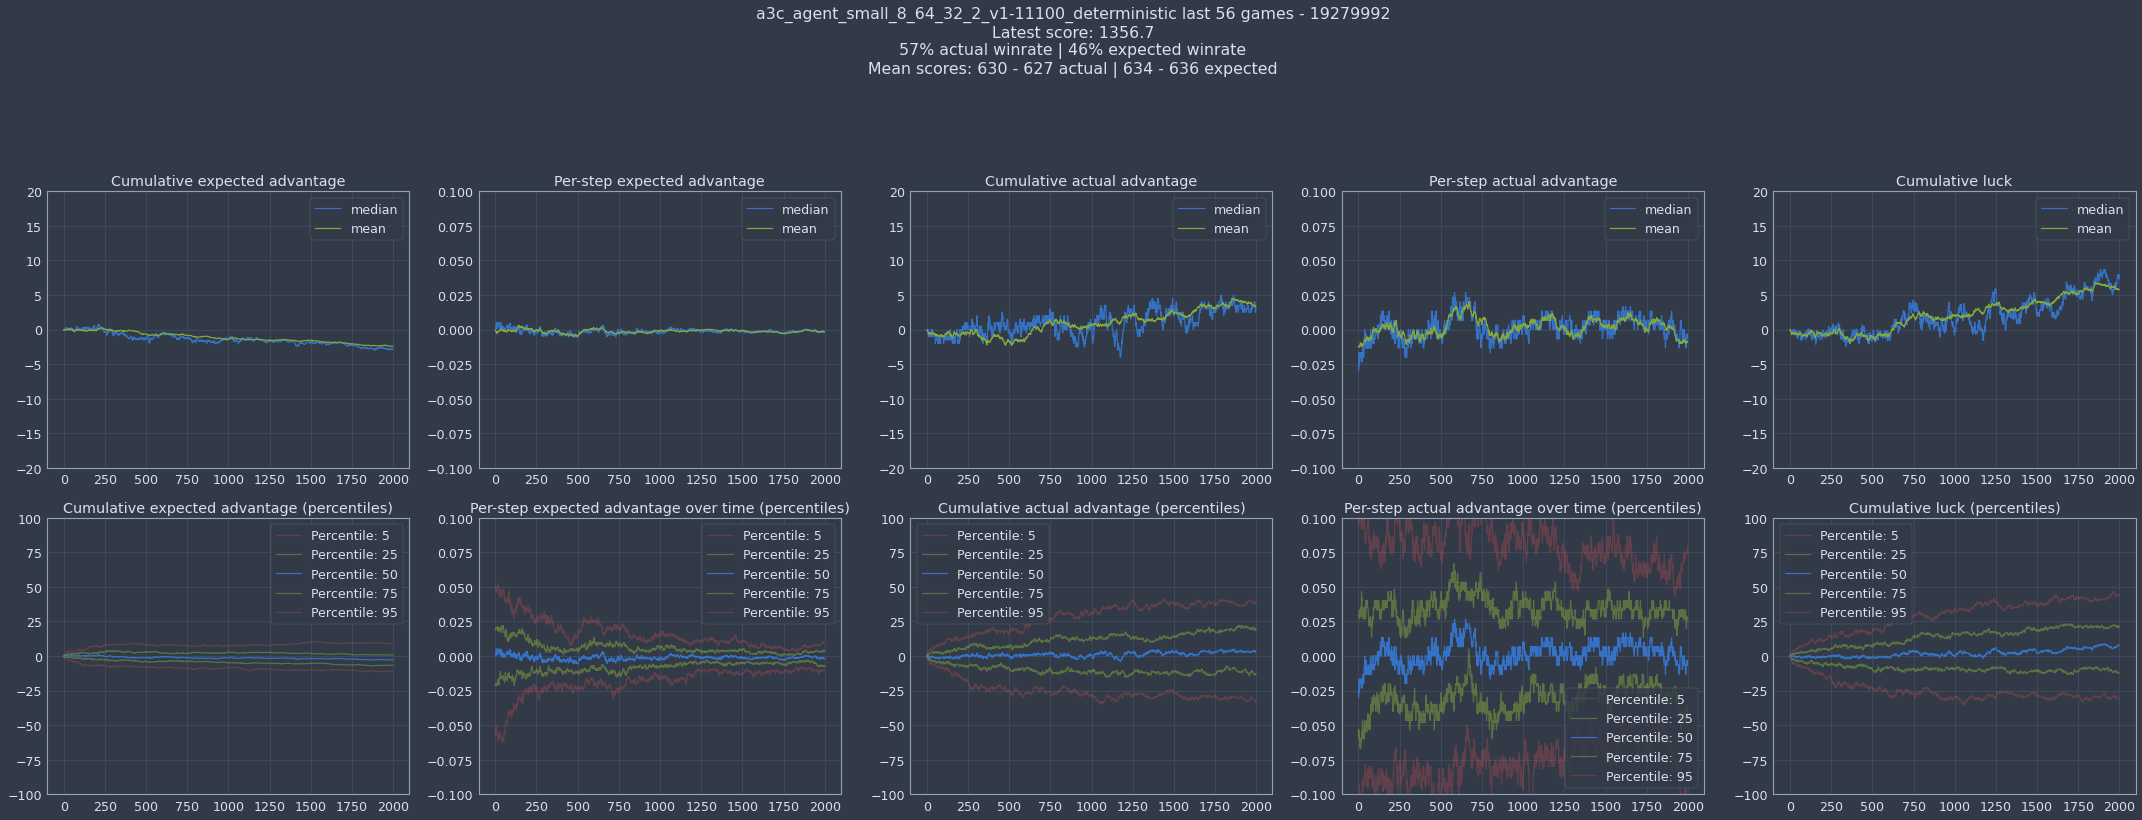

KeyboardInterrupt: 

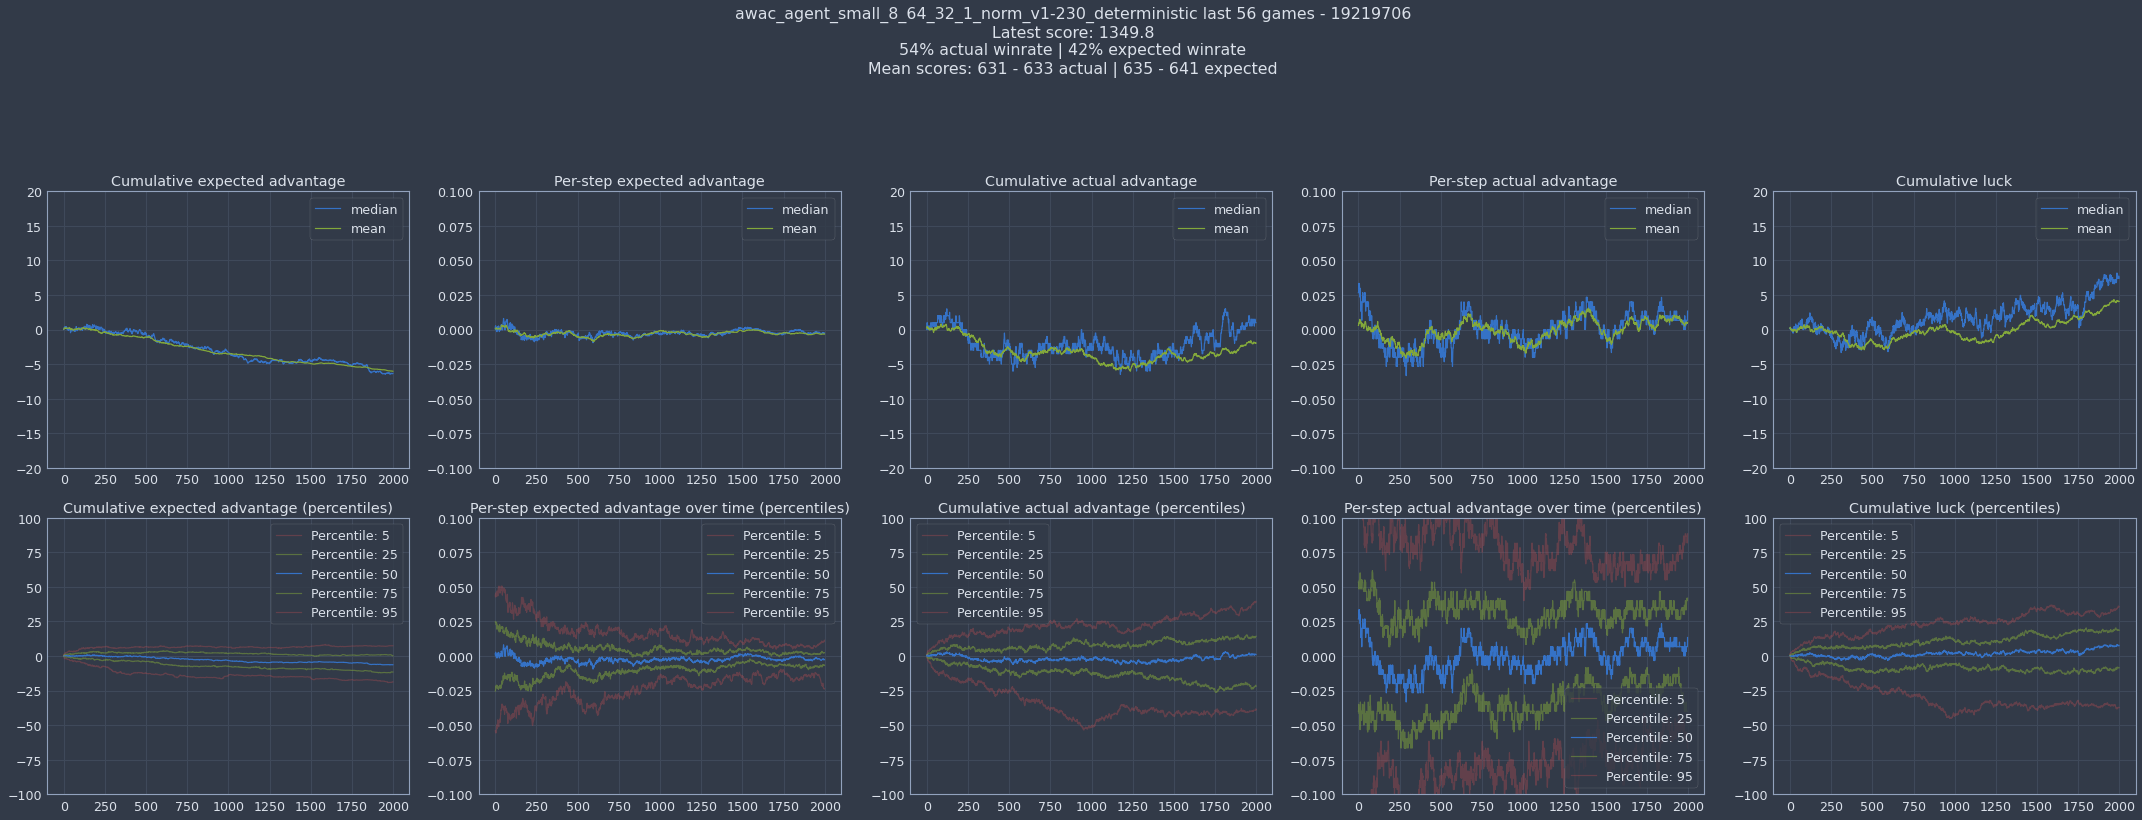

In [9]:
# >=1300 ELO
SUB_IDS = sub_id_to_model_name_df.index[sub_id_to_model_name_df['current_score'] >= 1300.]

for si in SUB_IDS:
    generate_fig(sub_id=si,
                 last_n_games=8*7,
                 save=True)

## Generate figures for all models

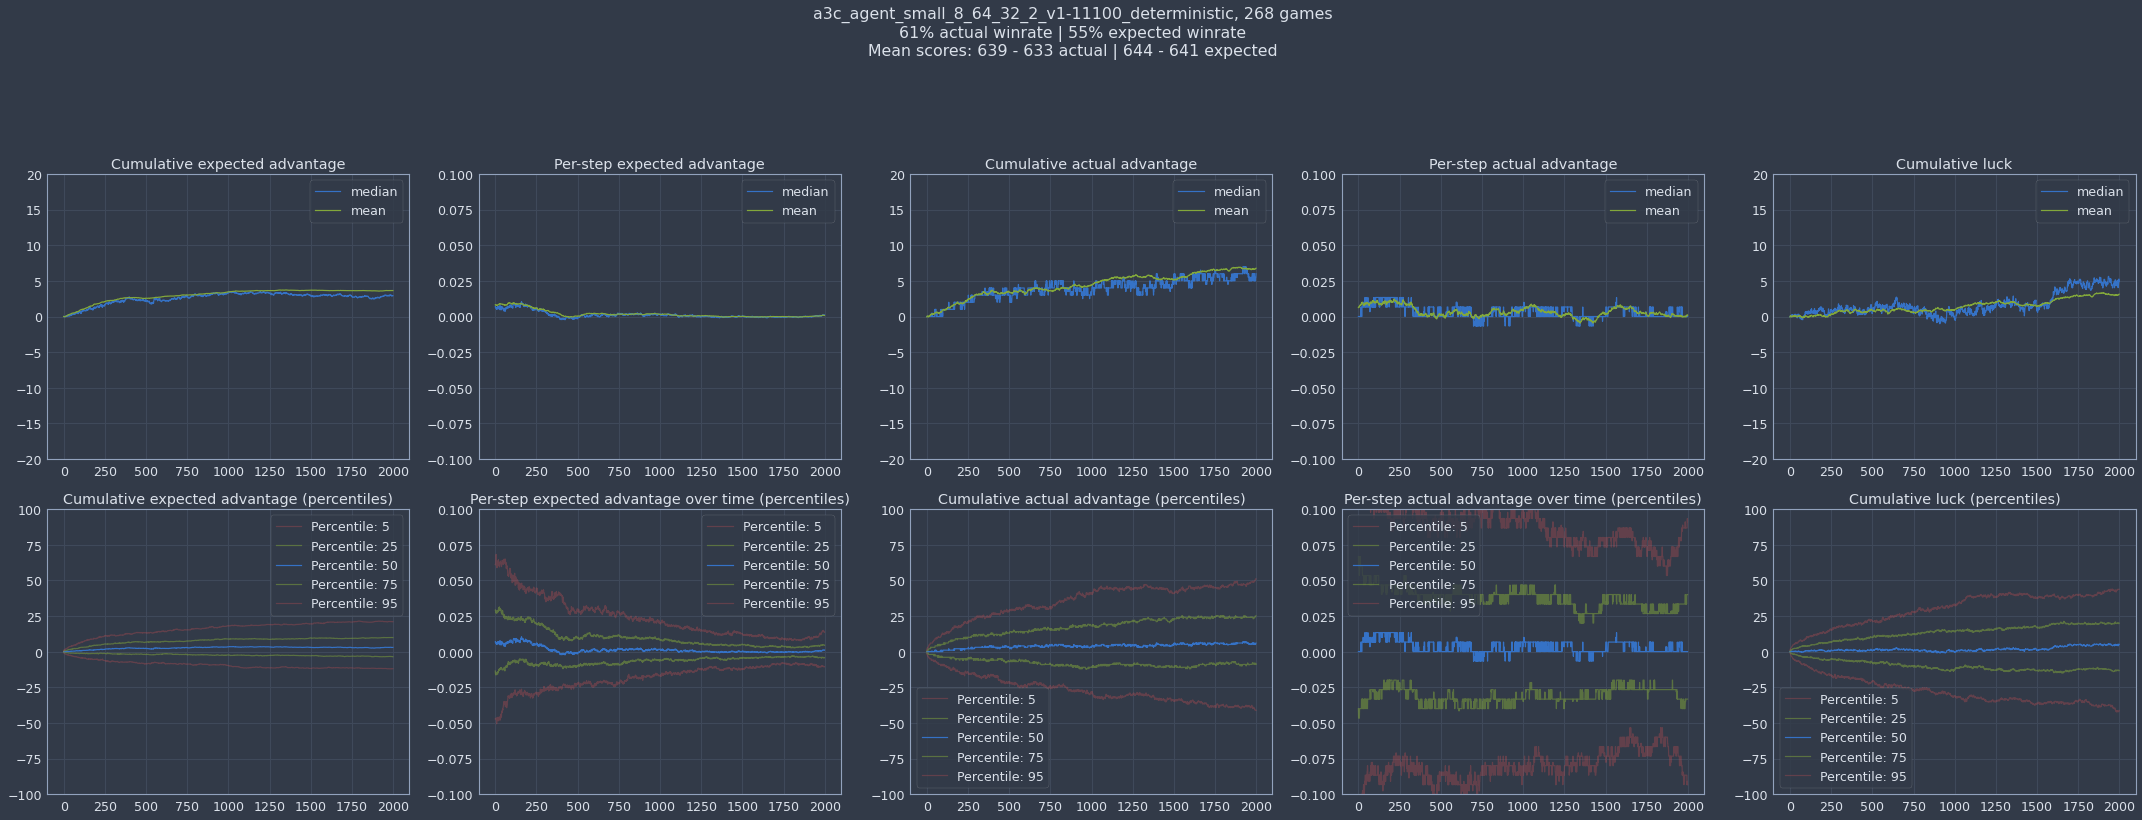

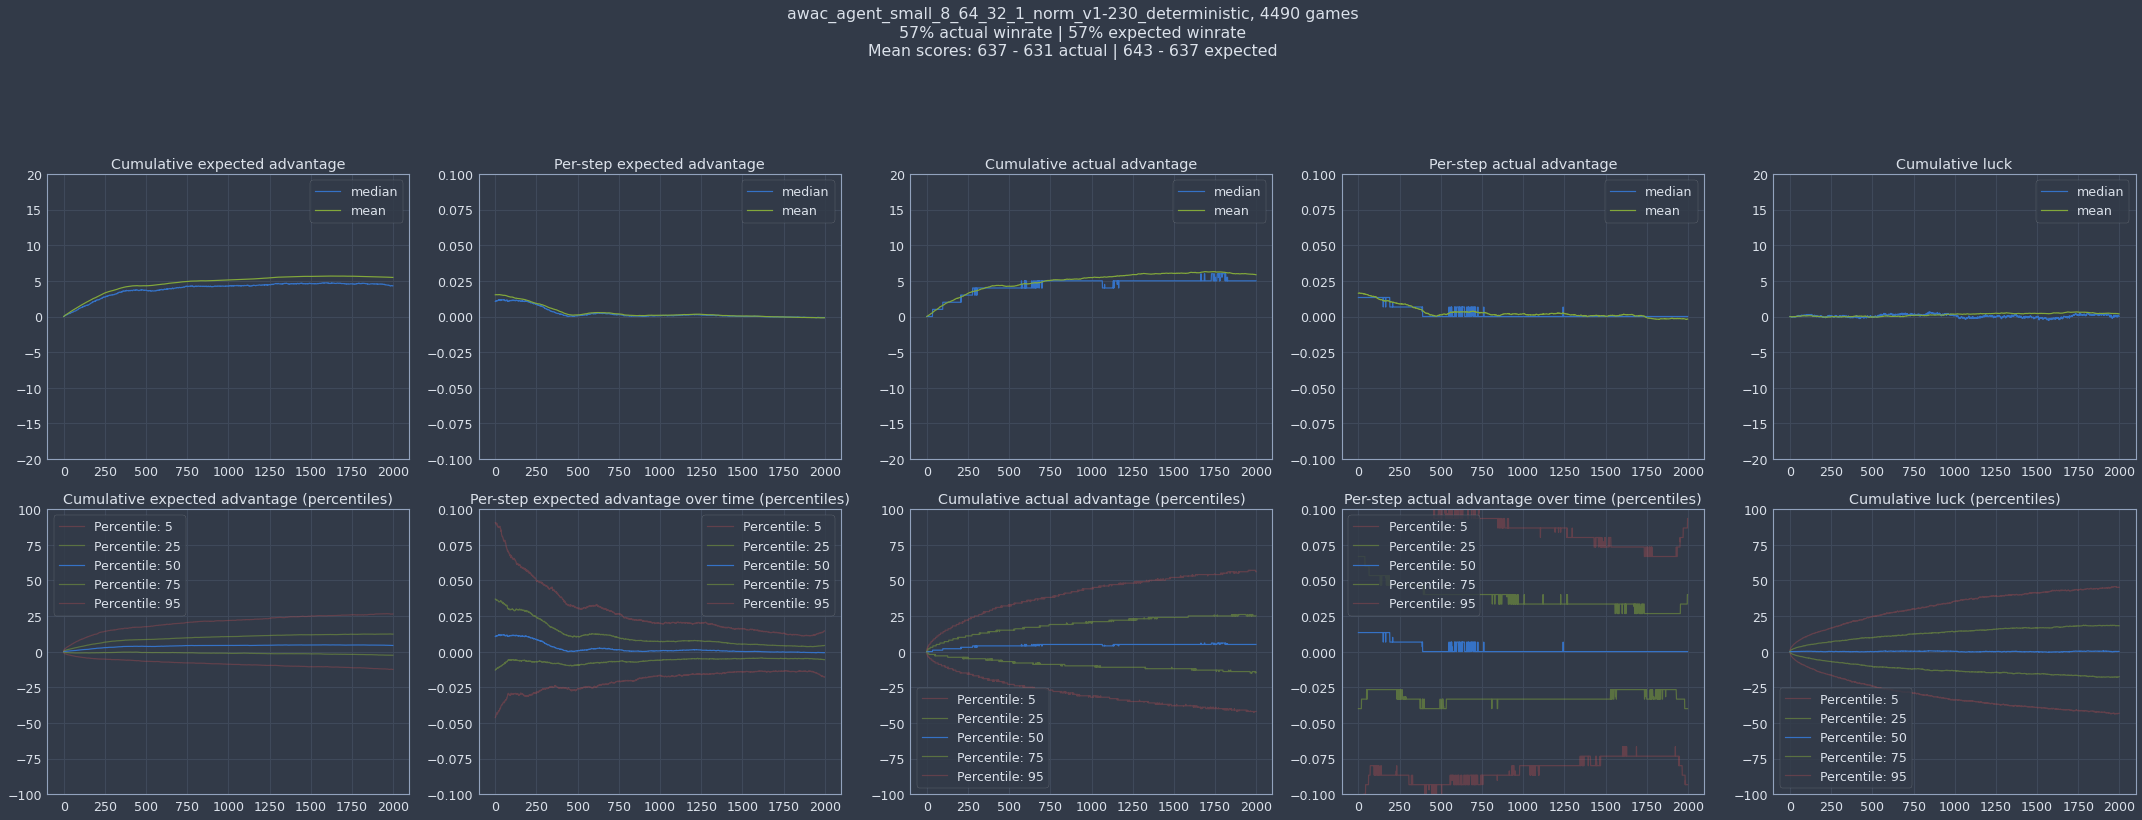

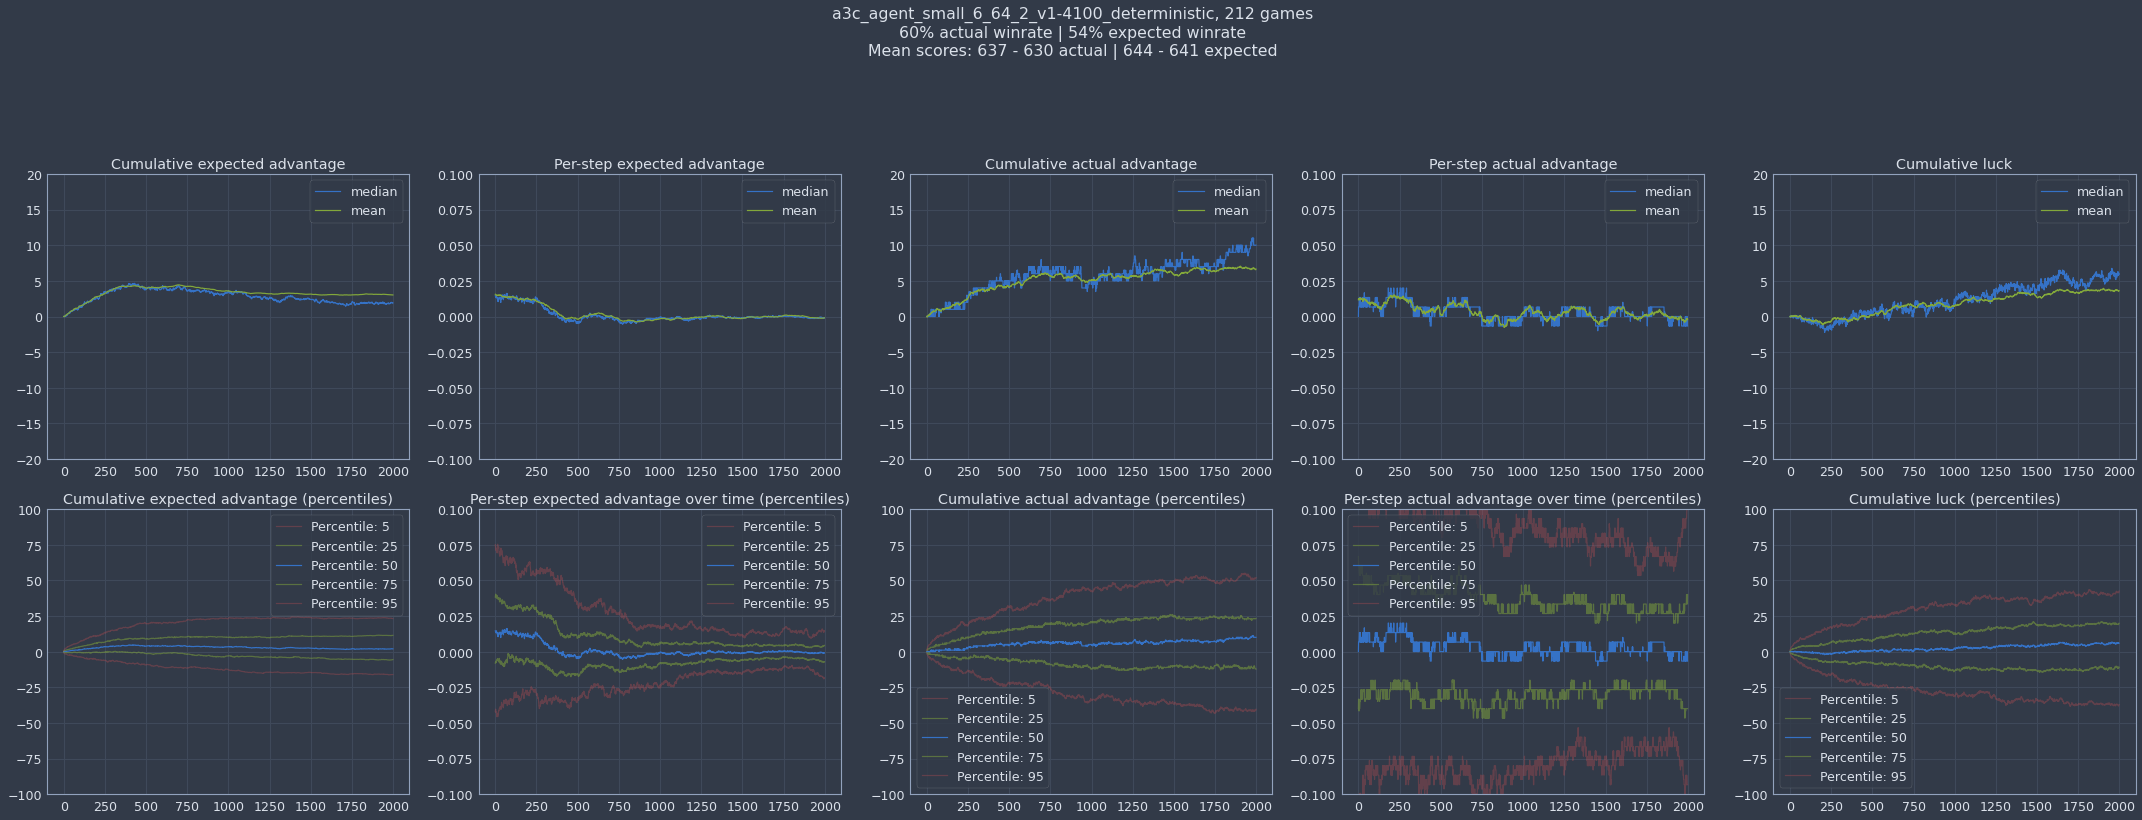

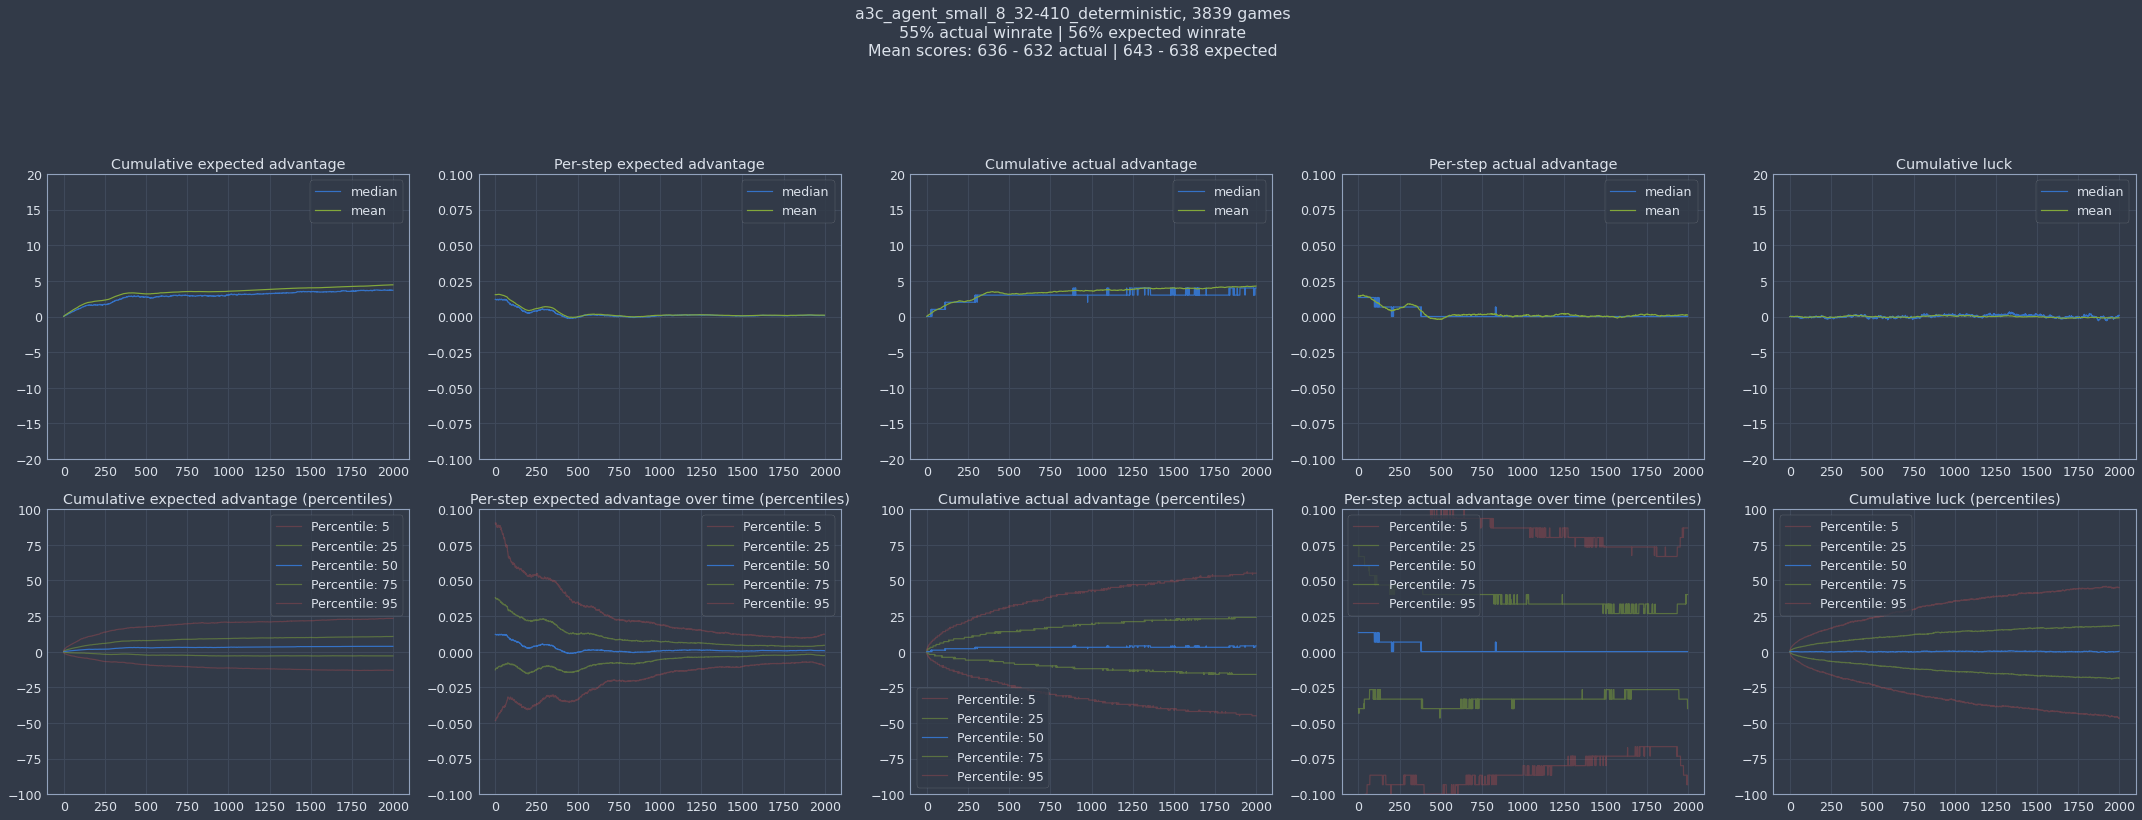

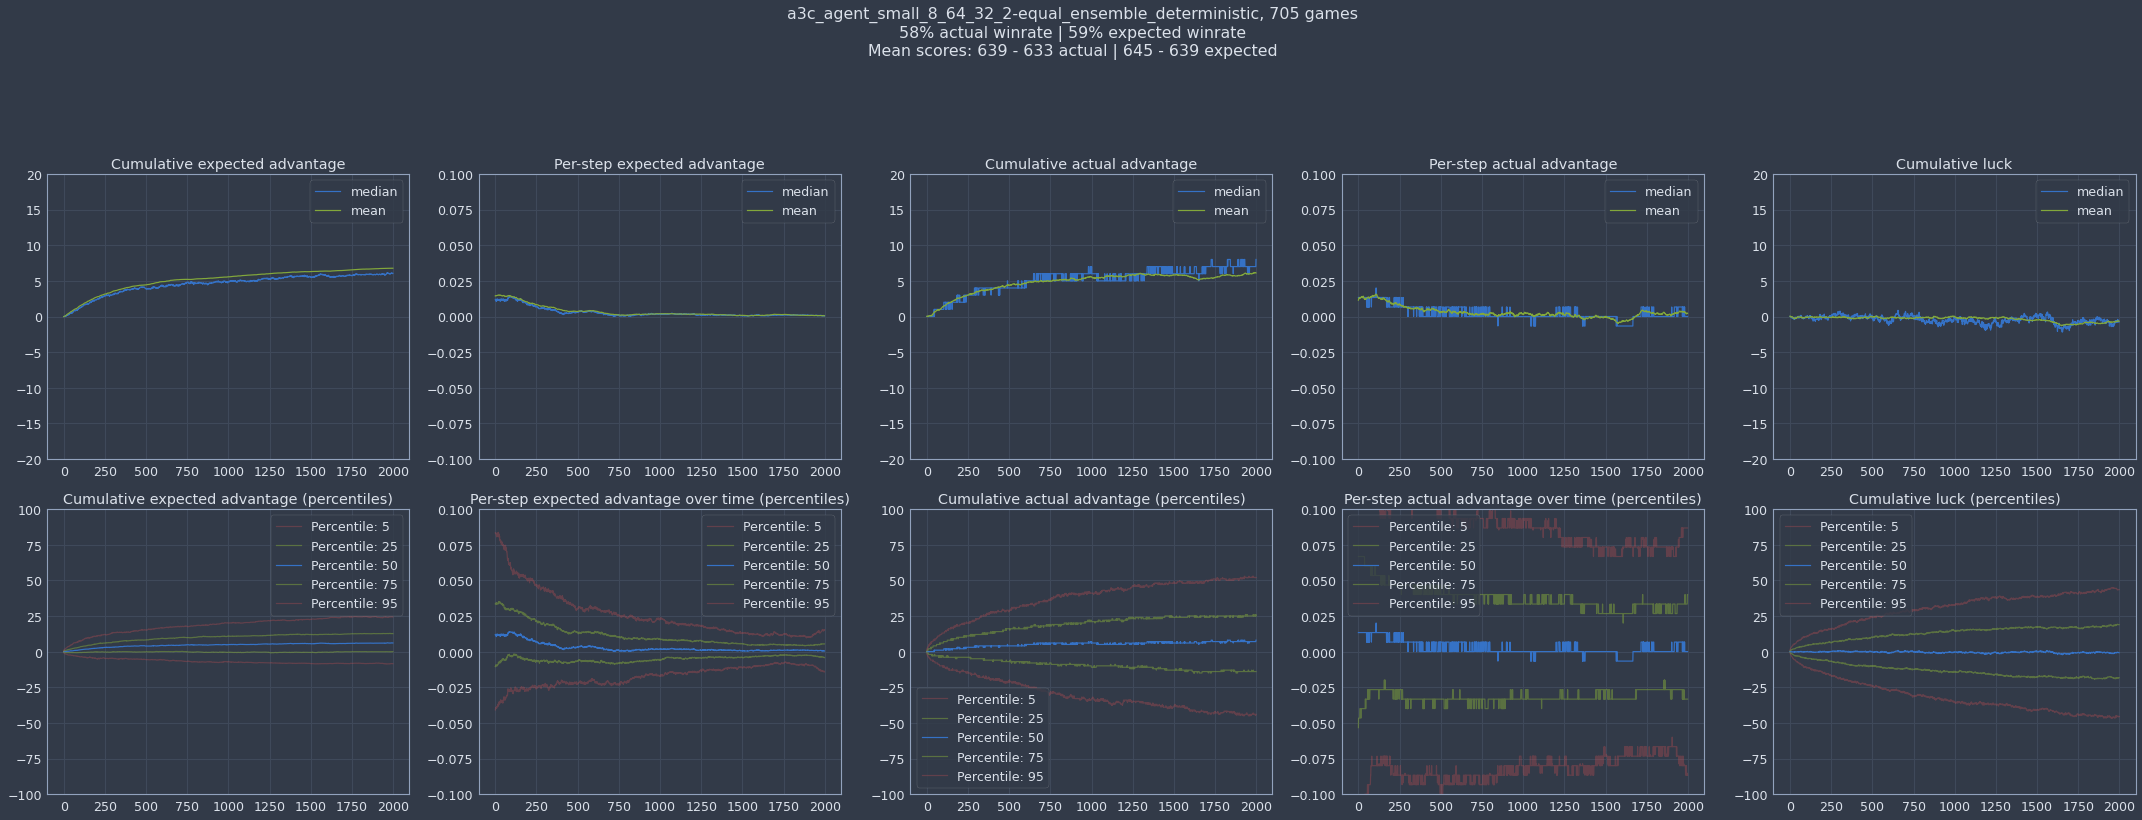

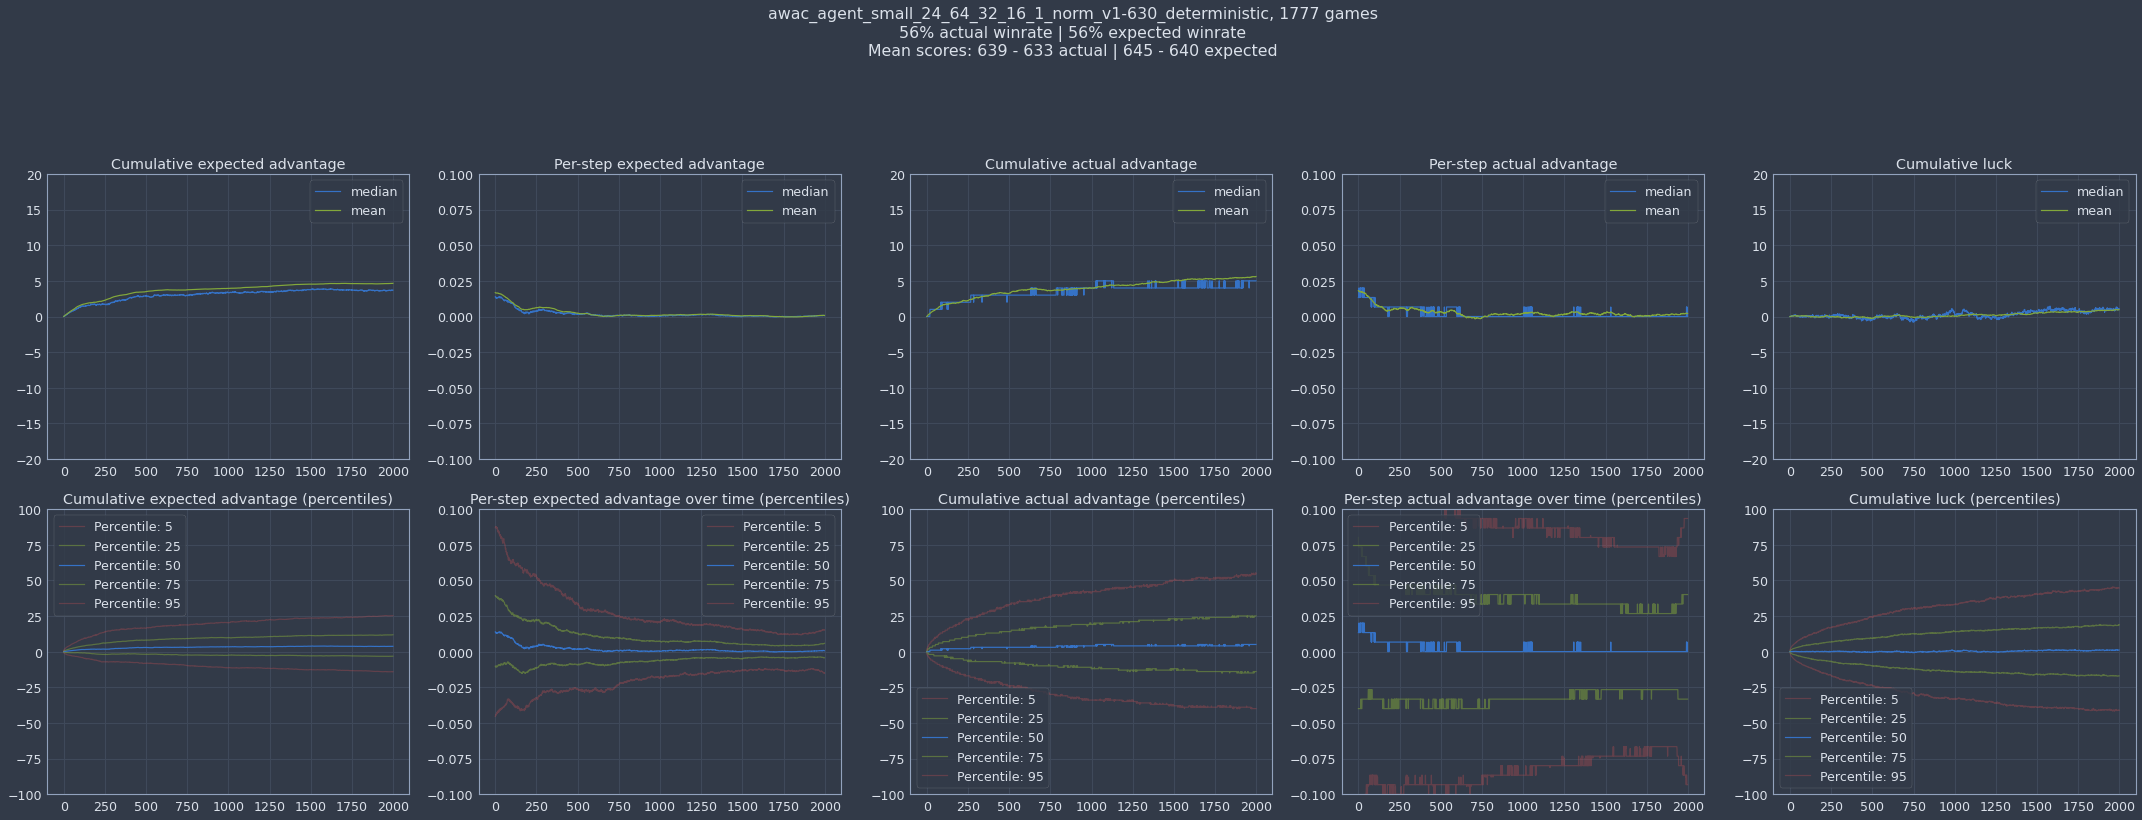

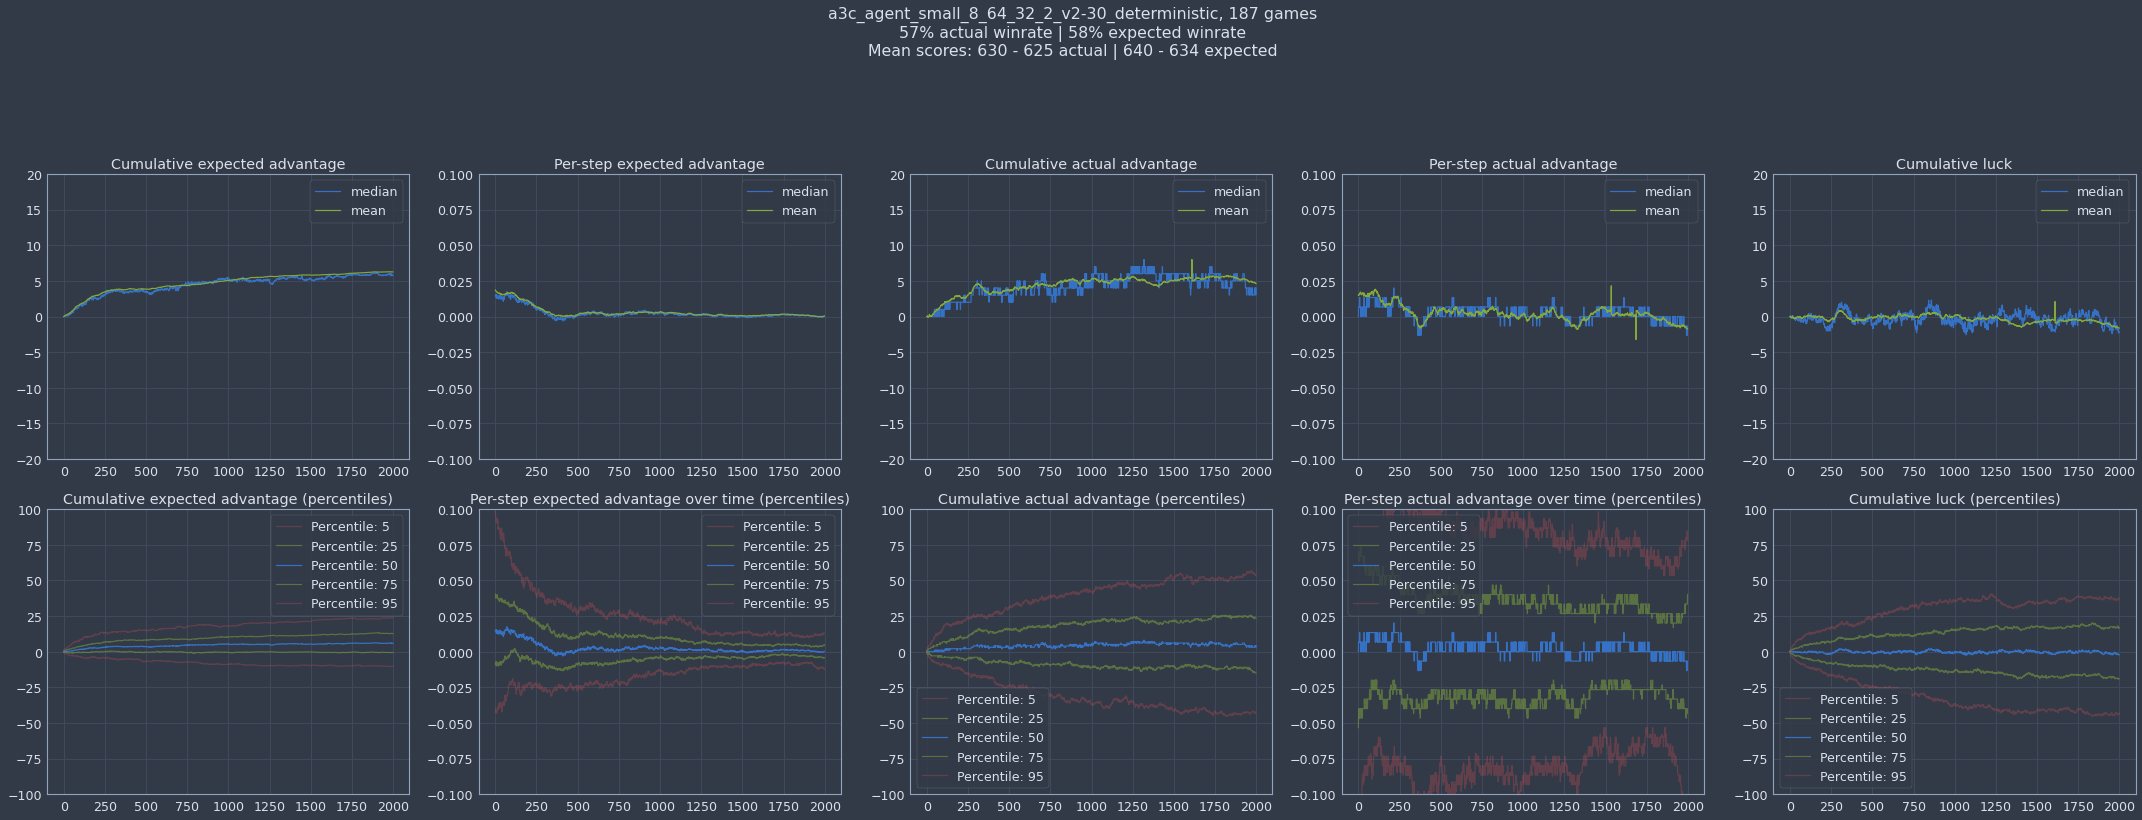

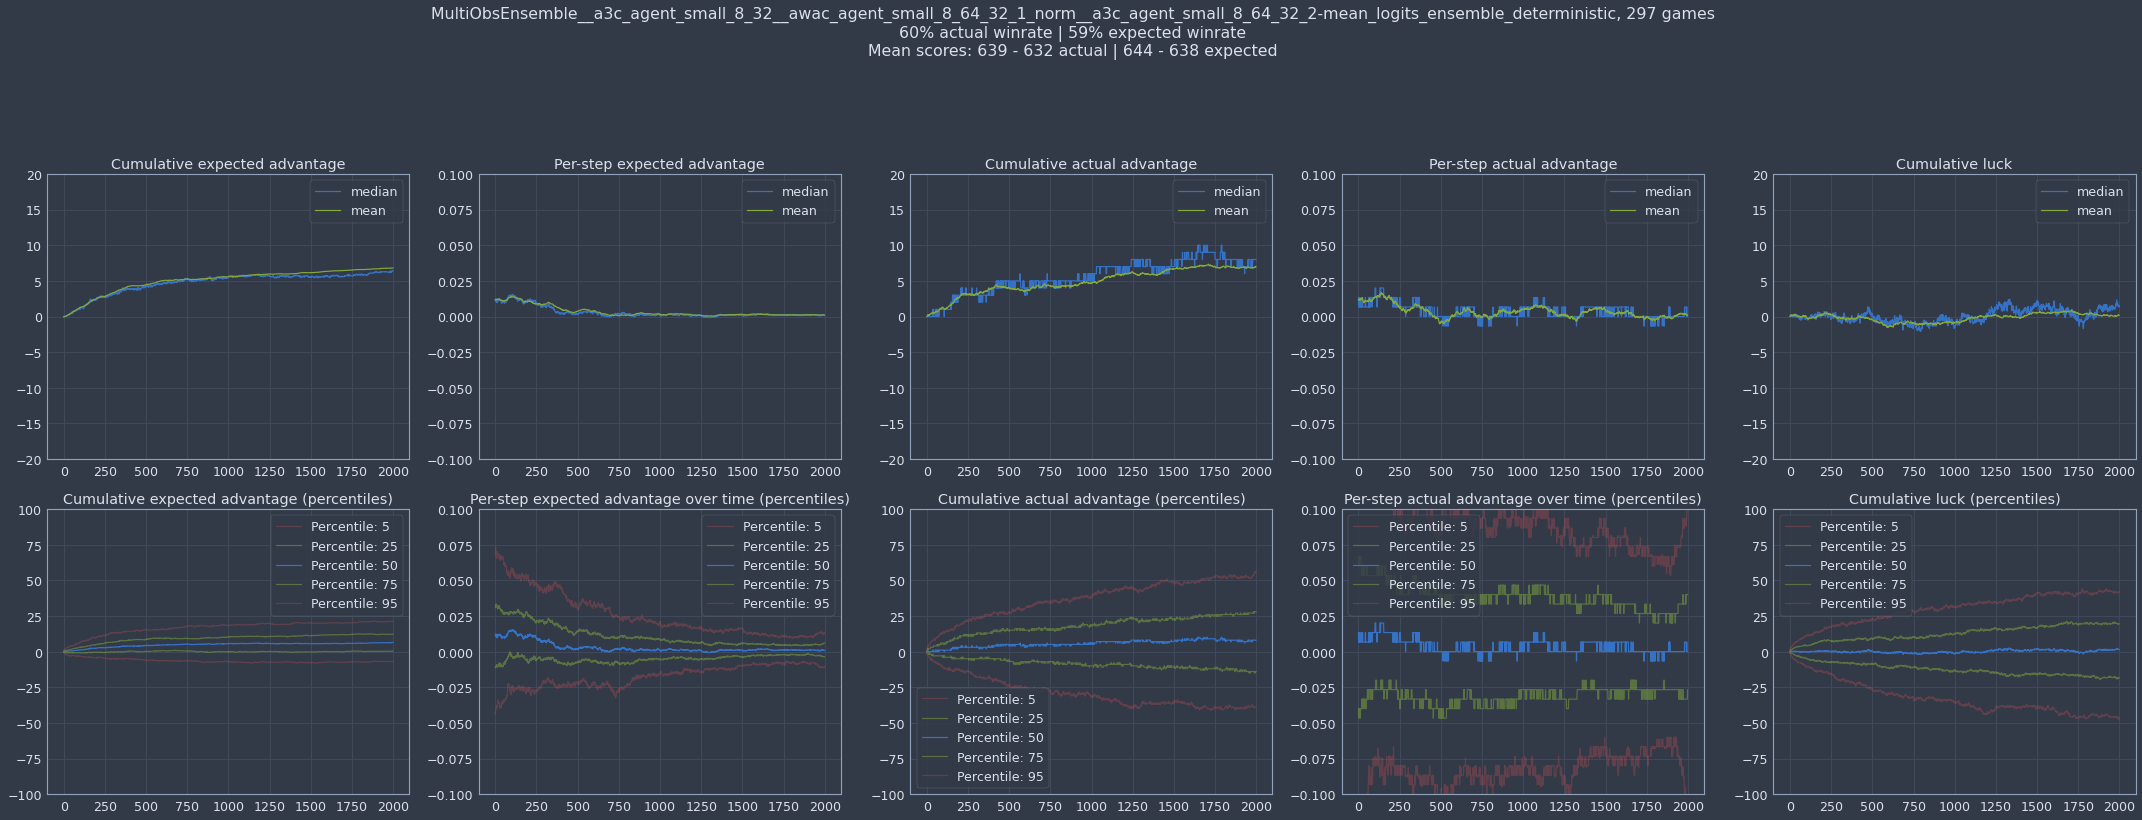

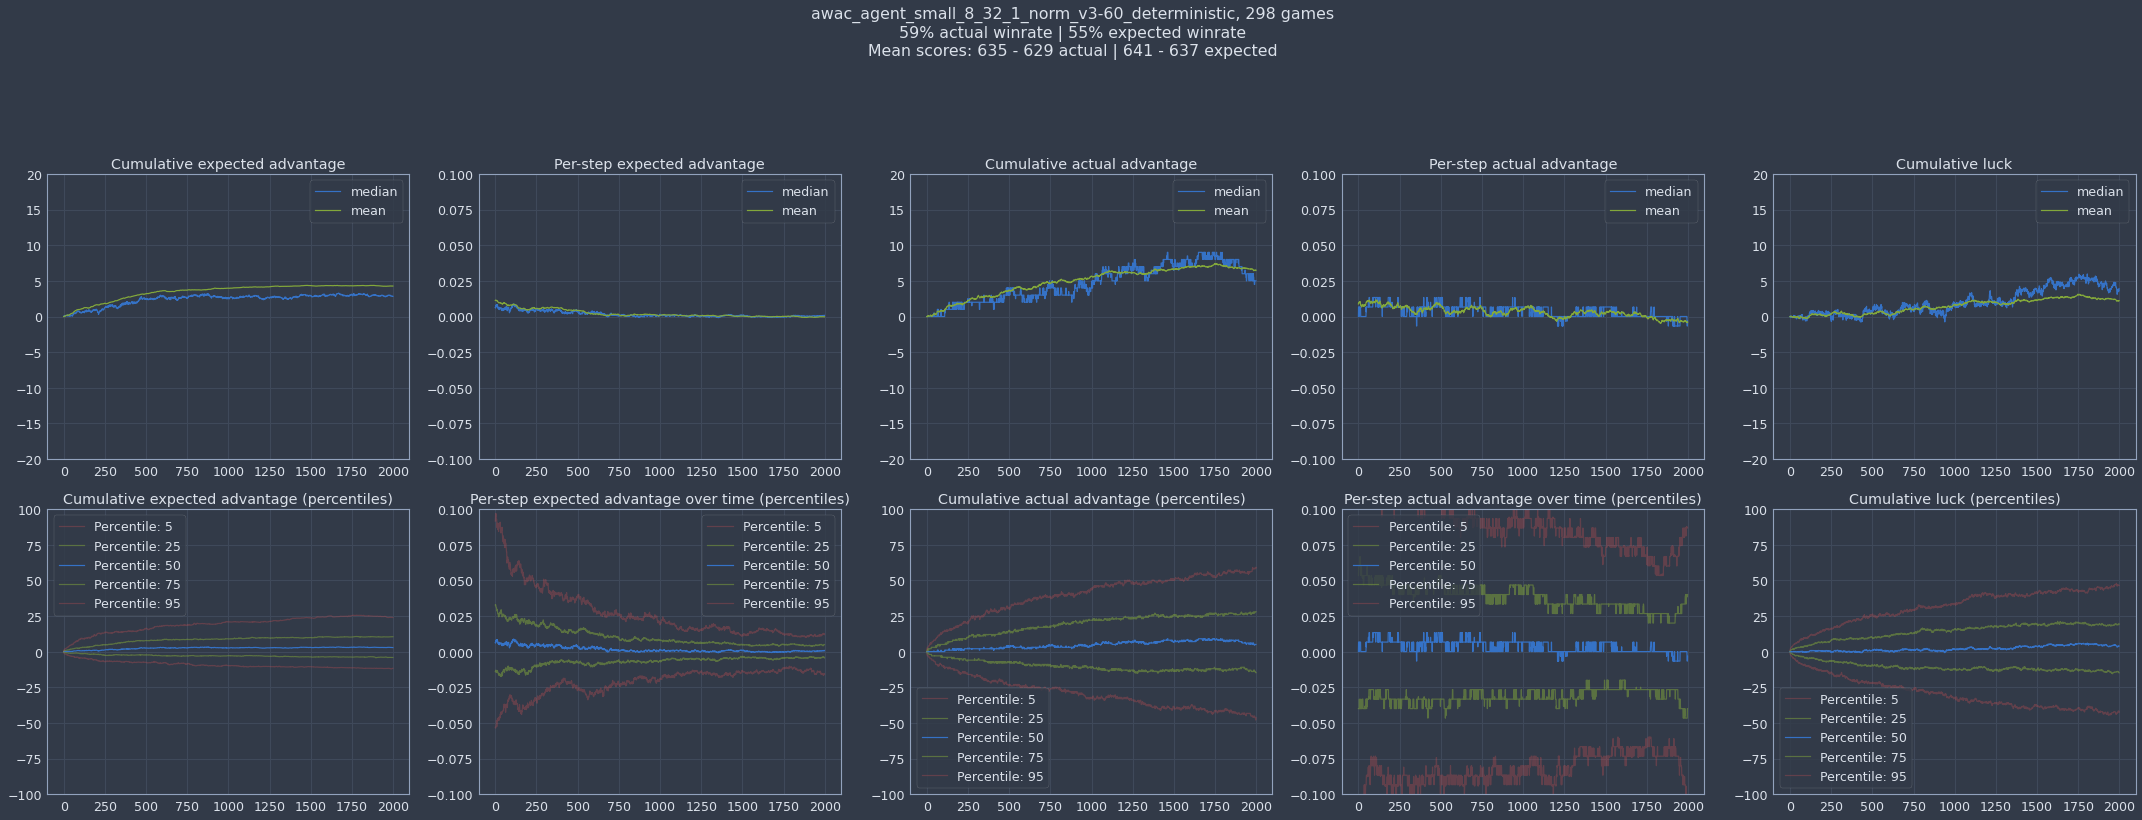

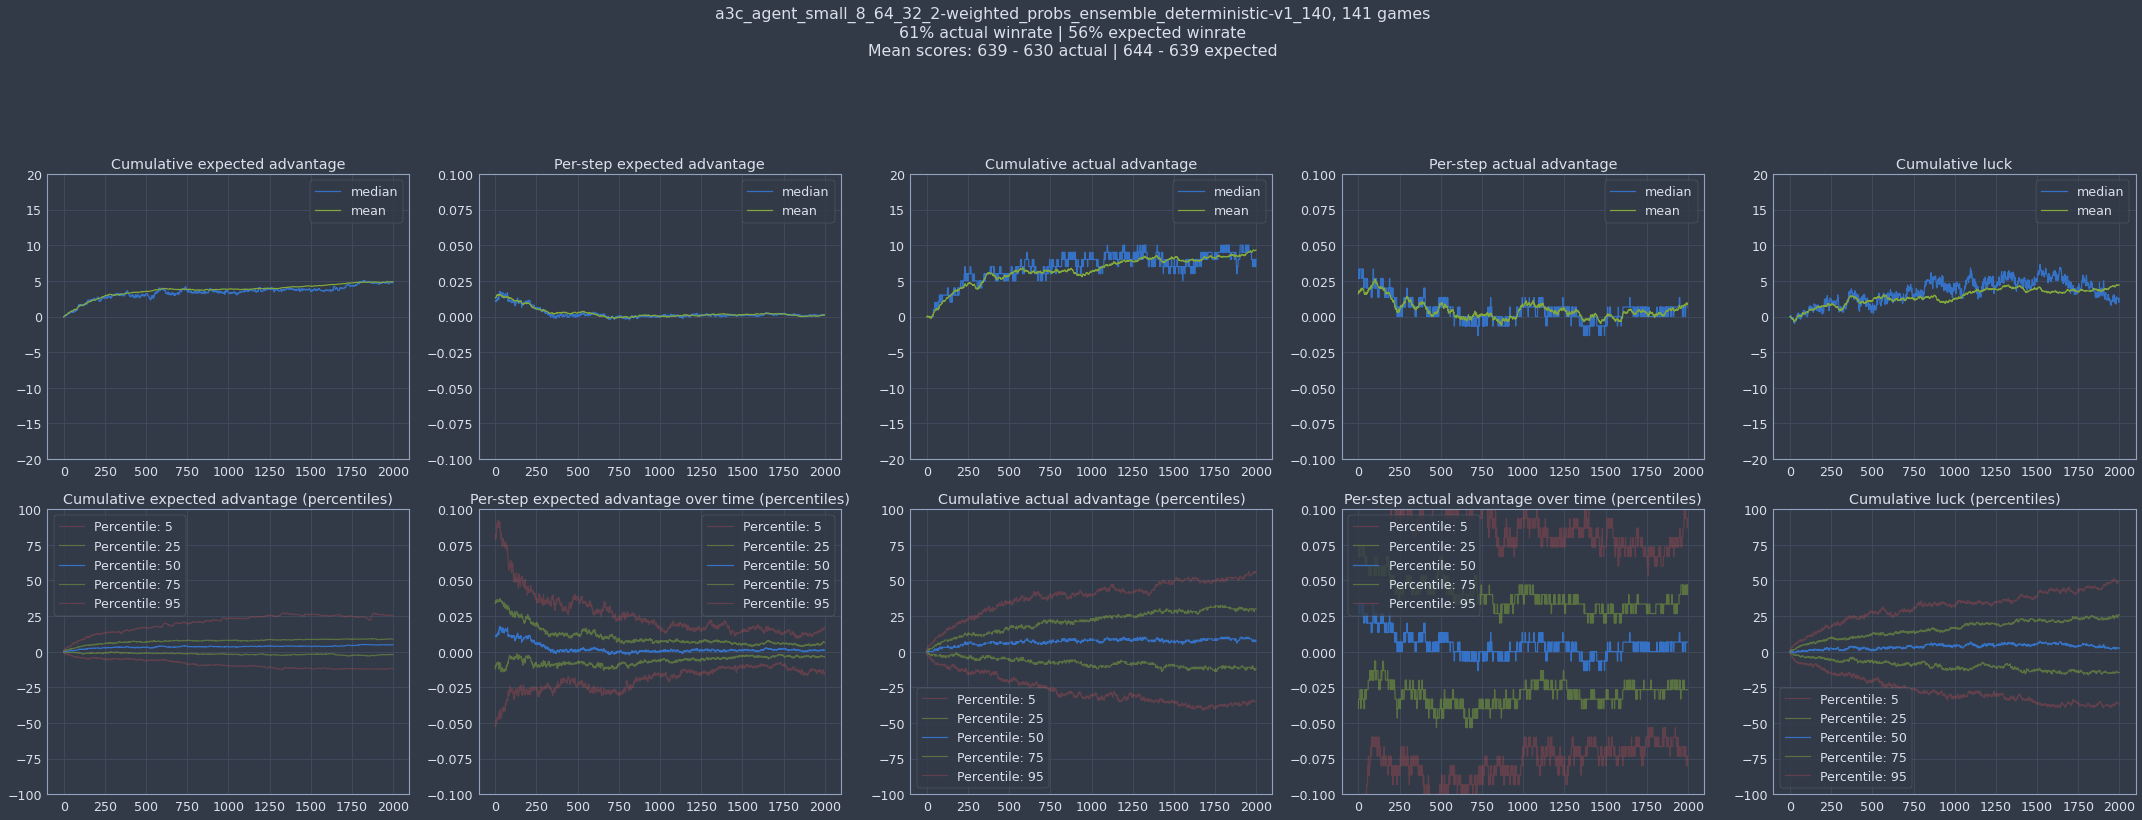

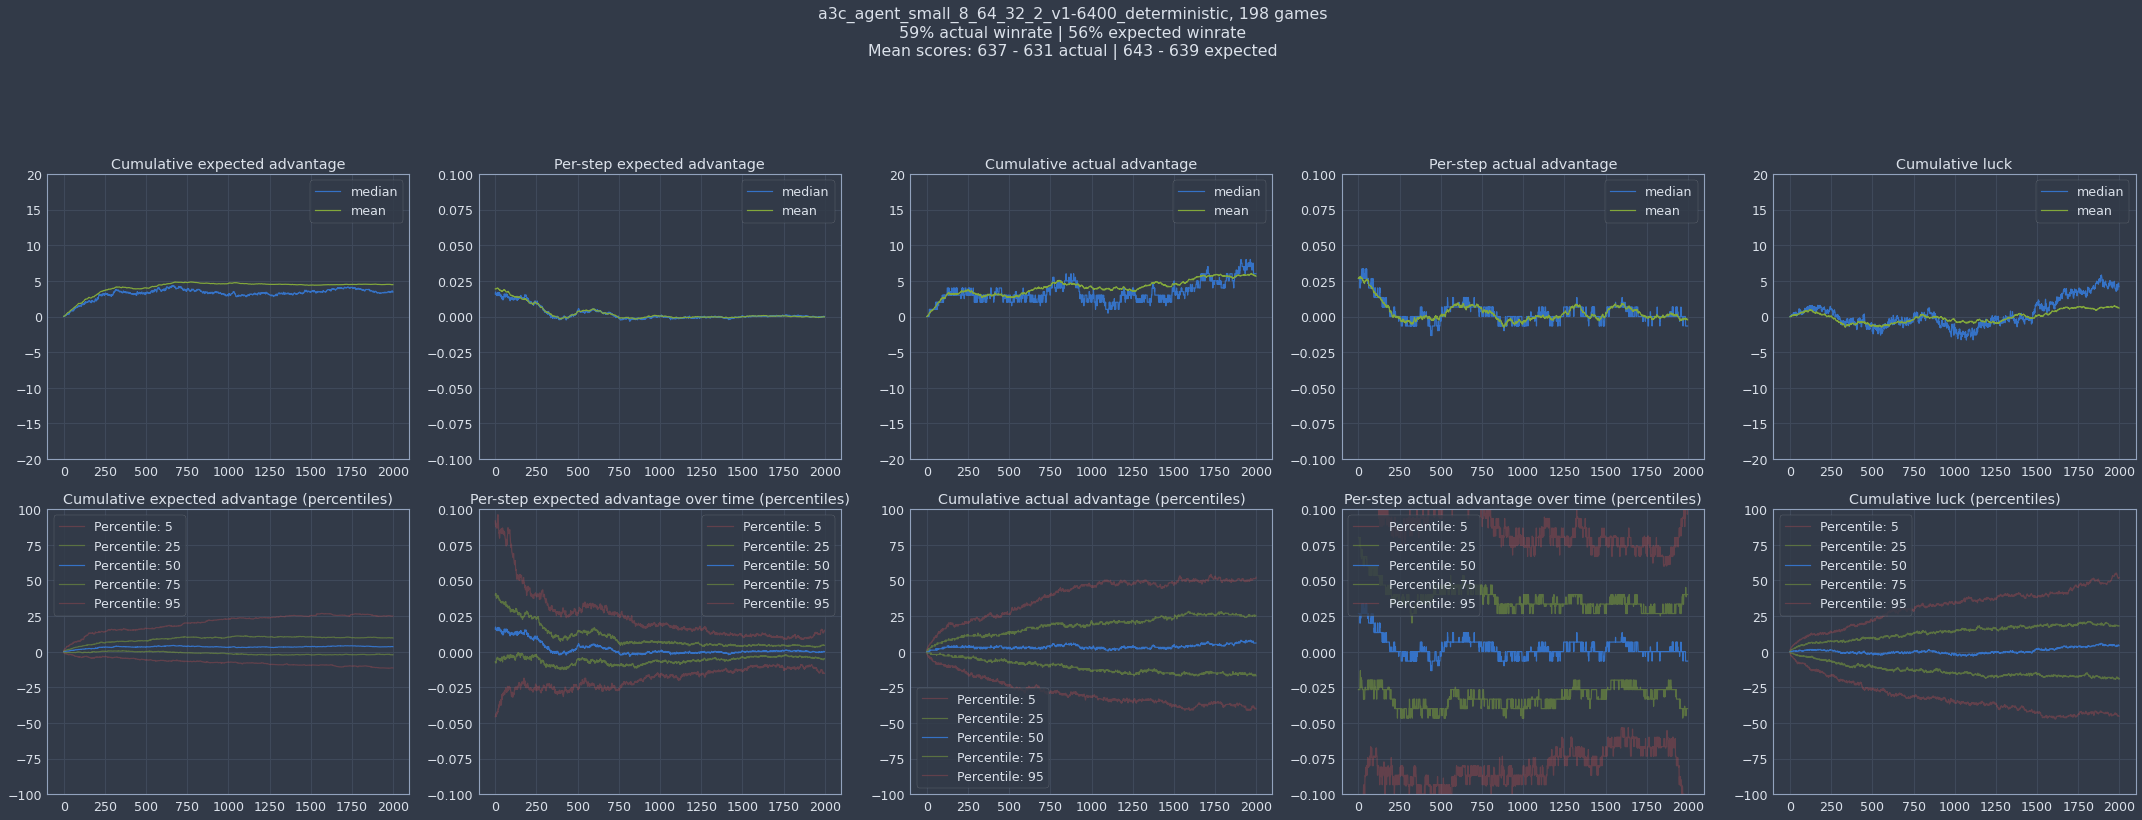

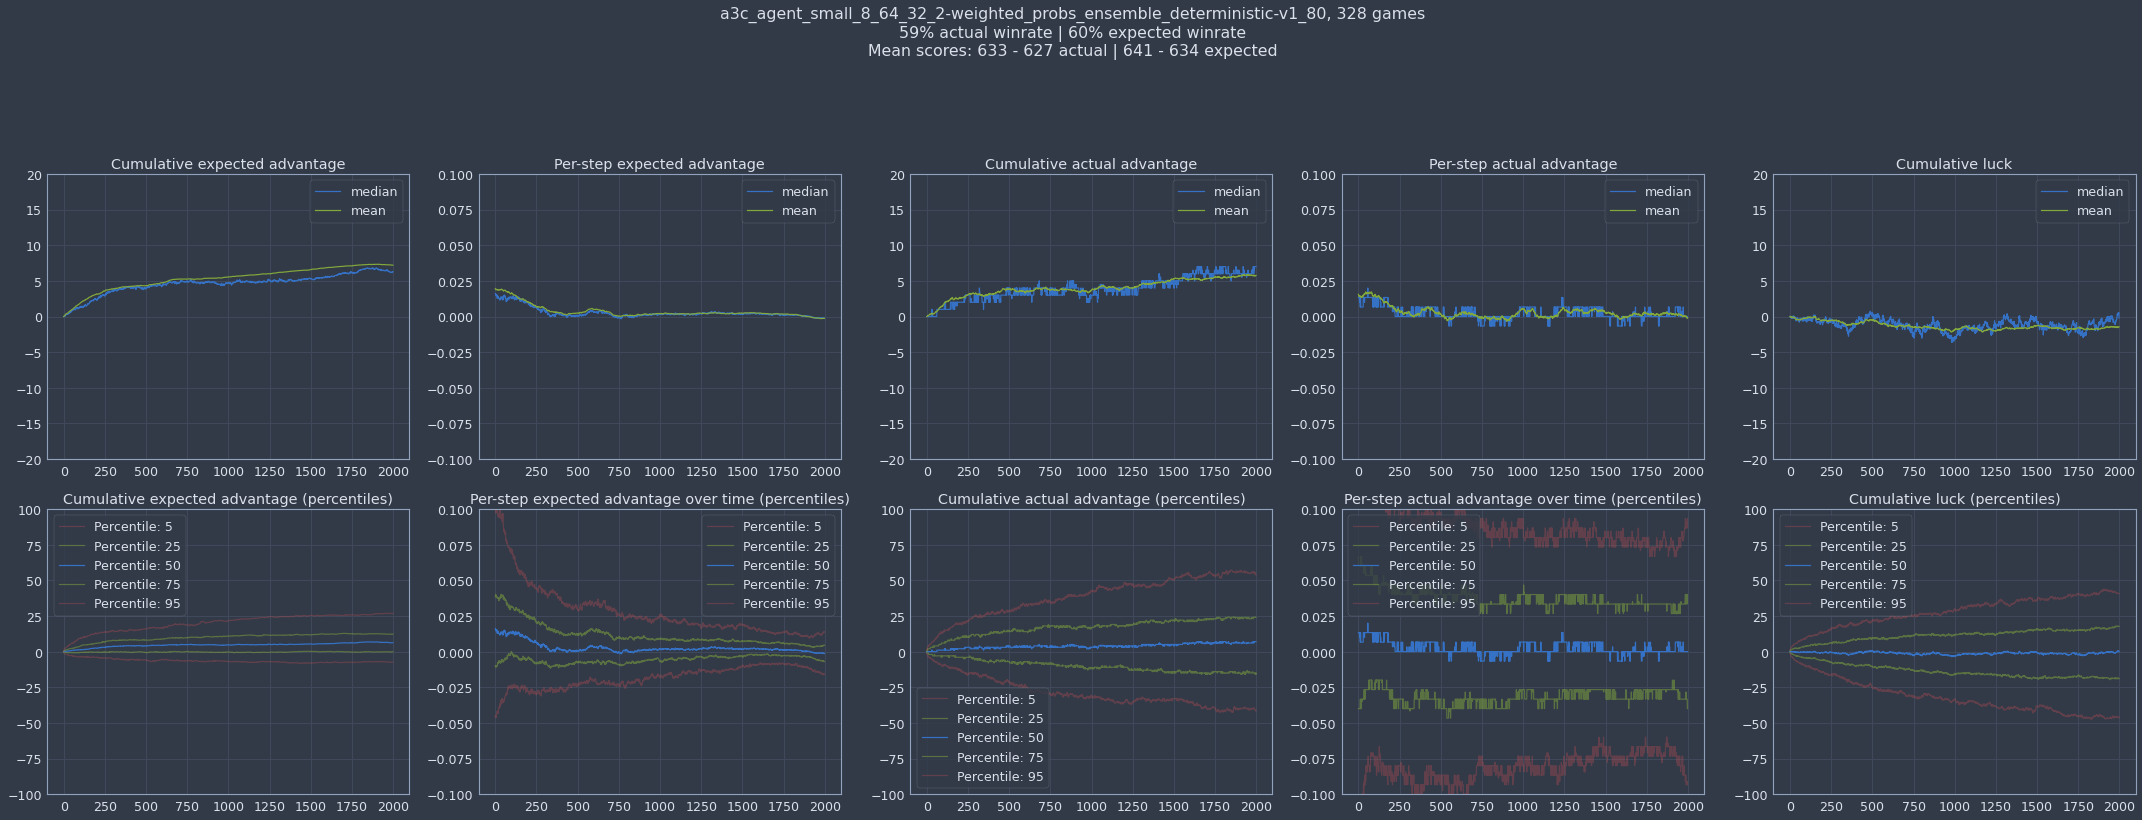

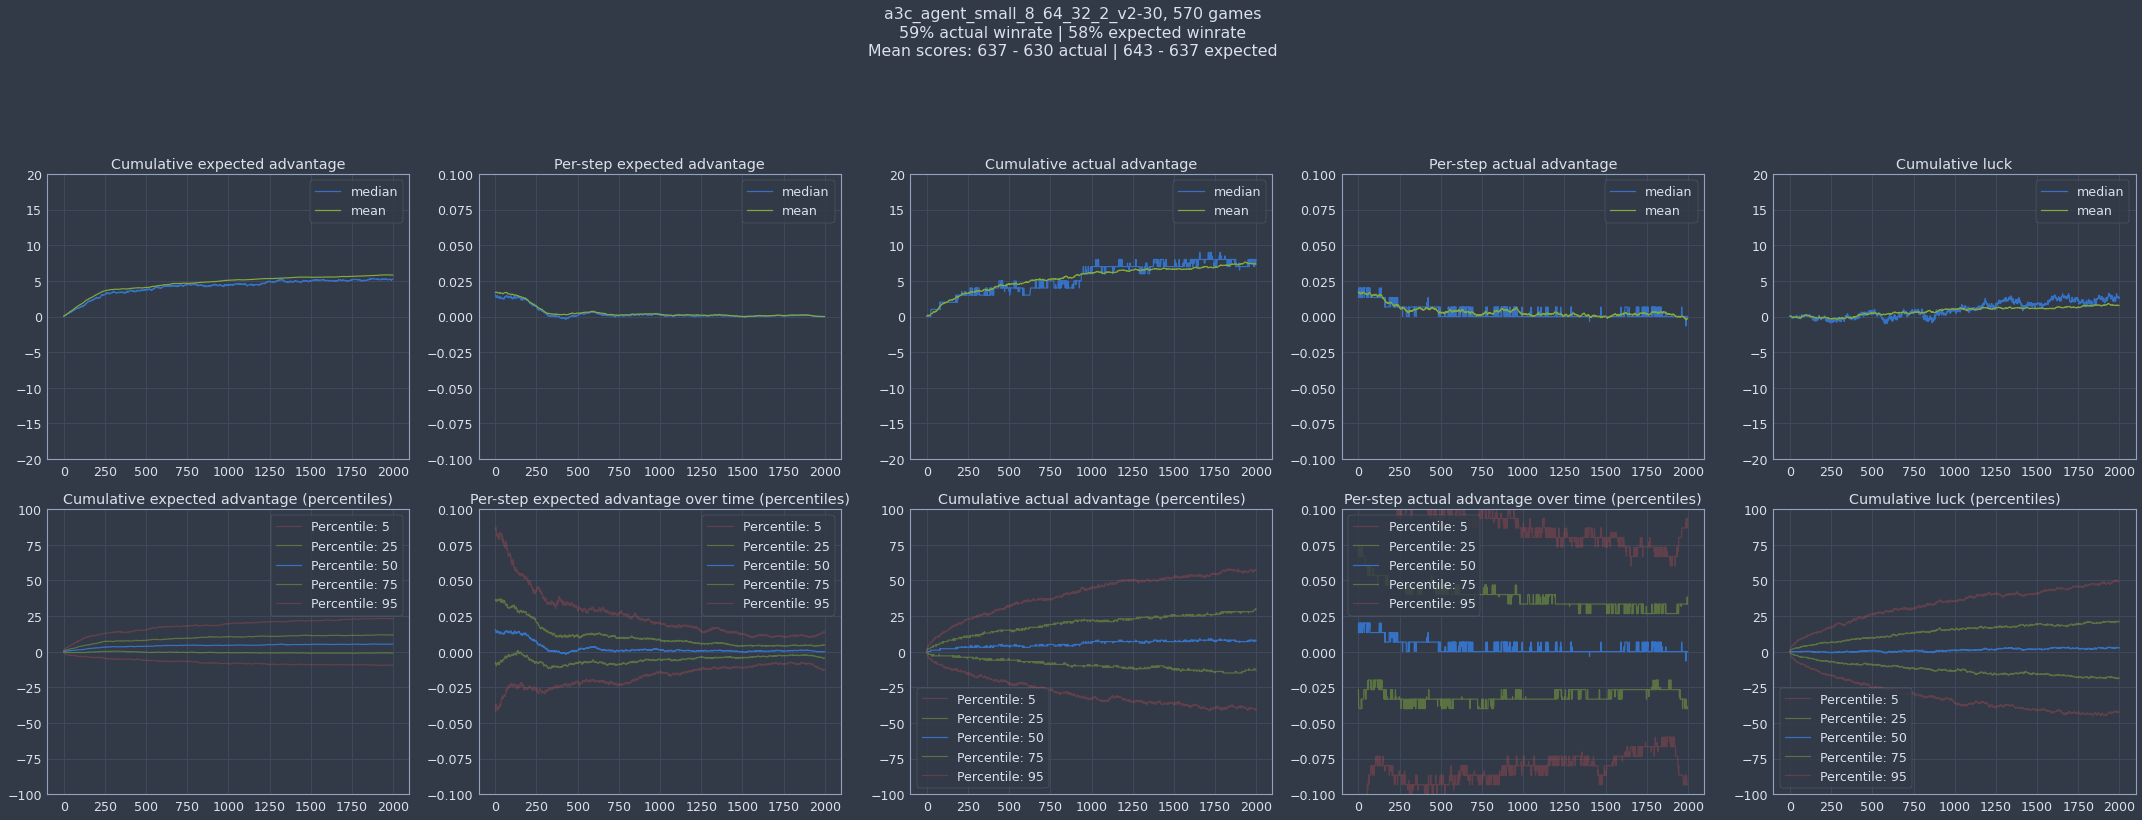

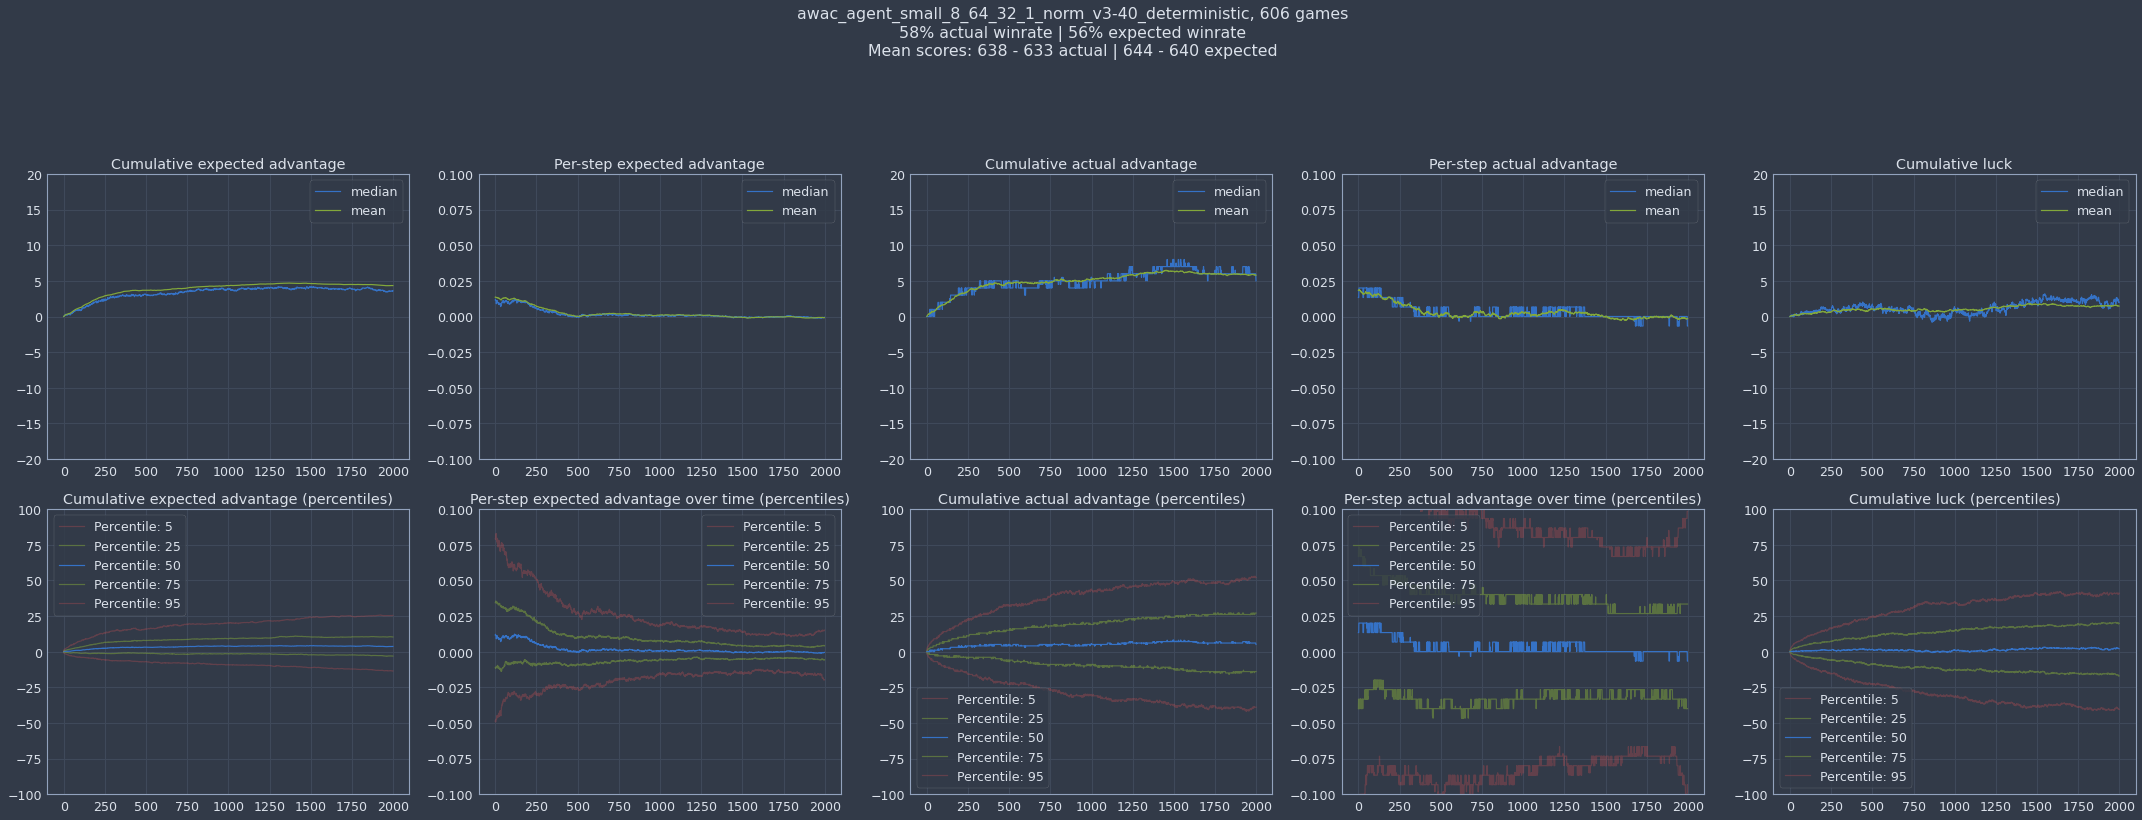

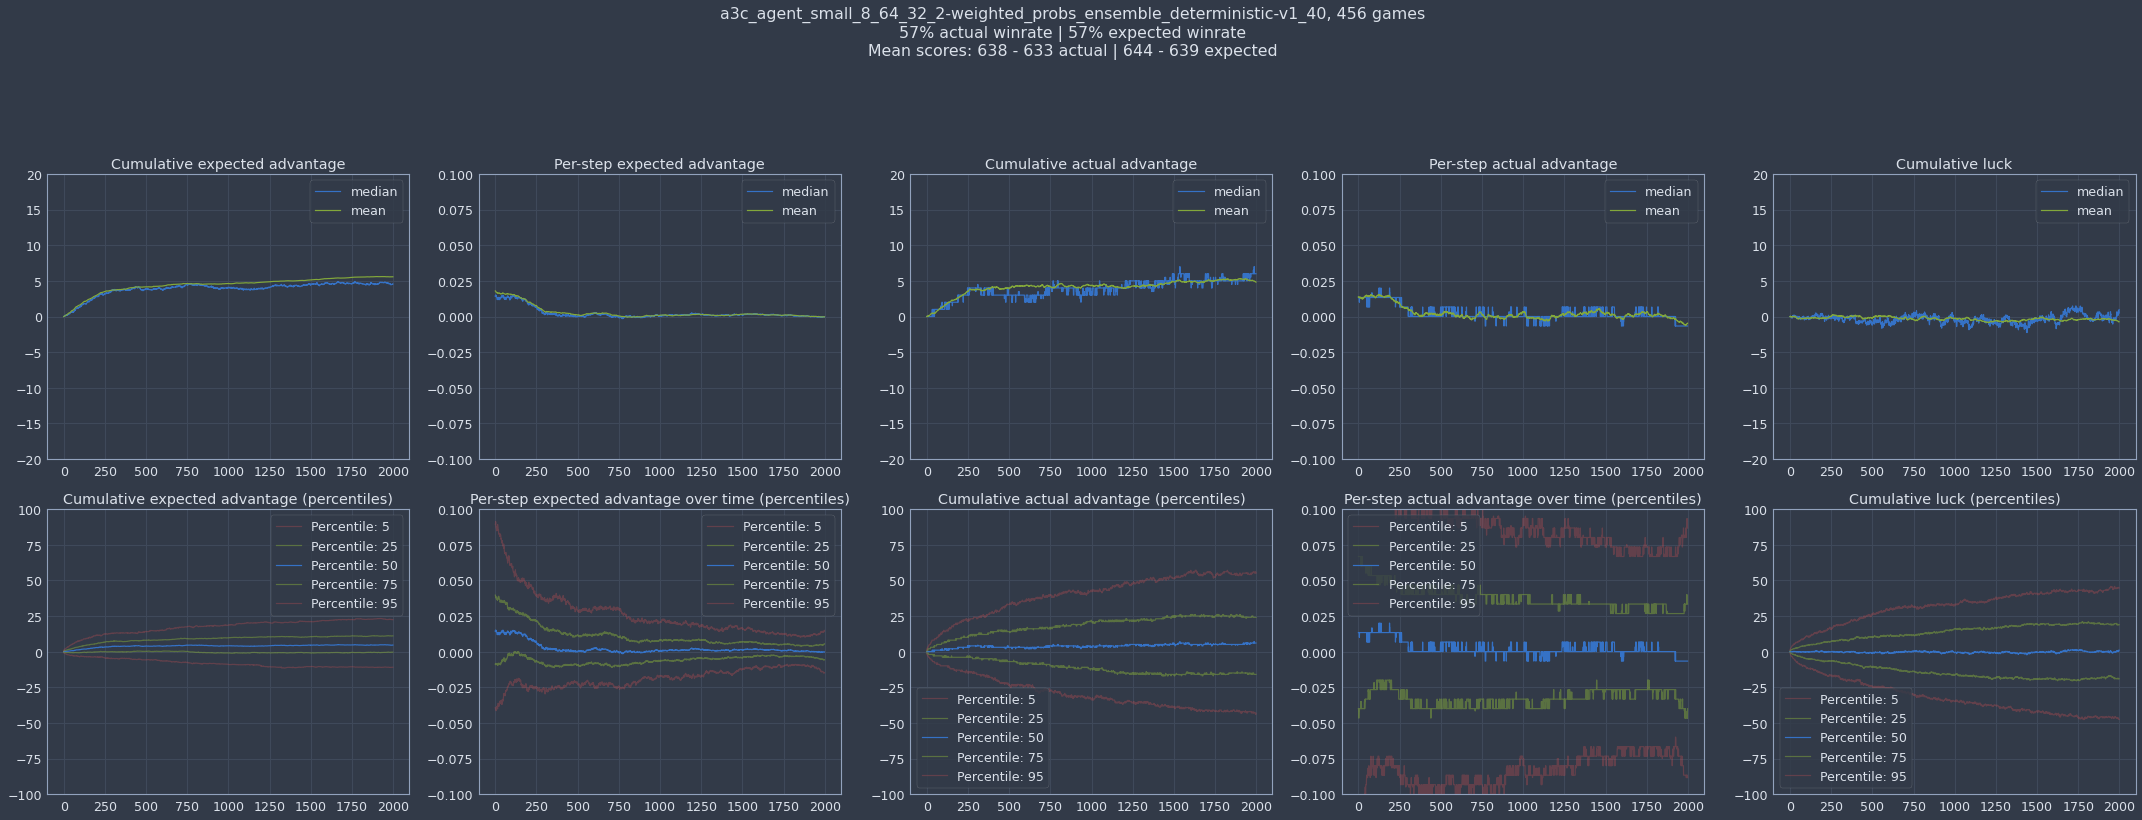

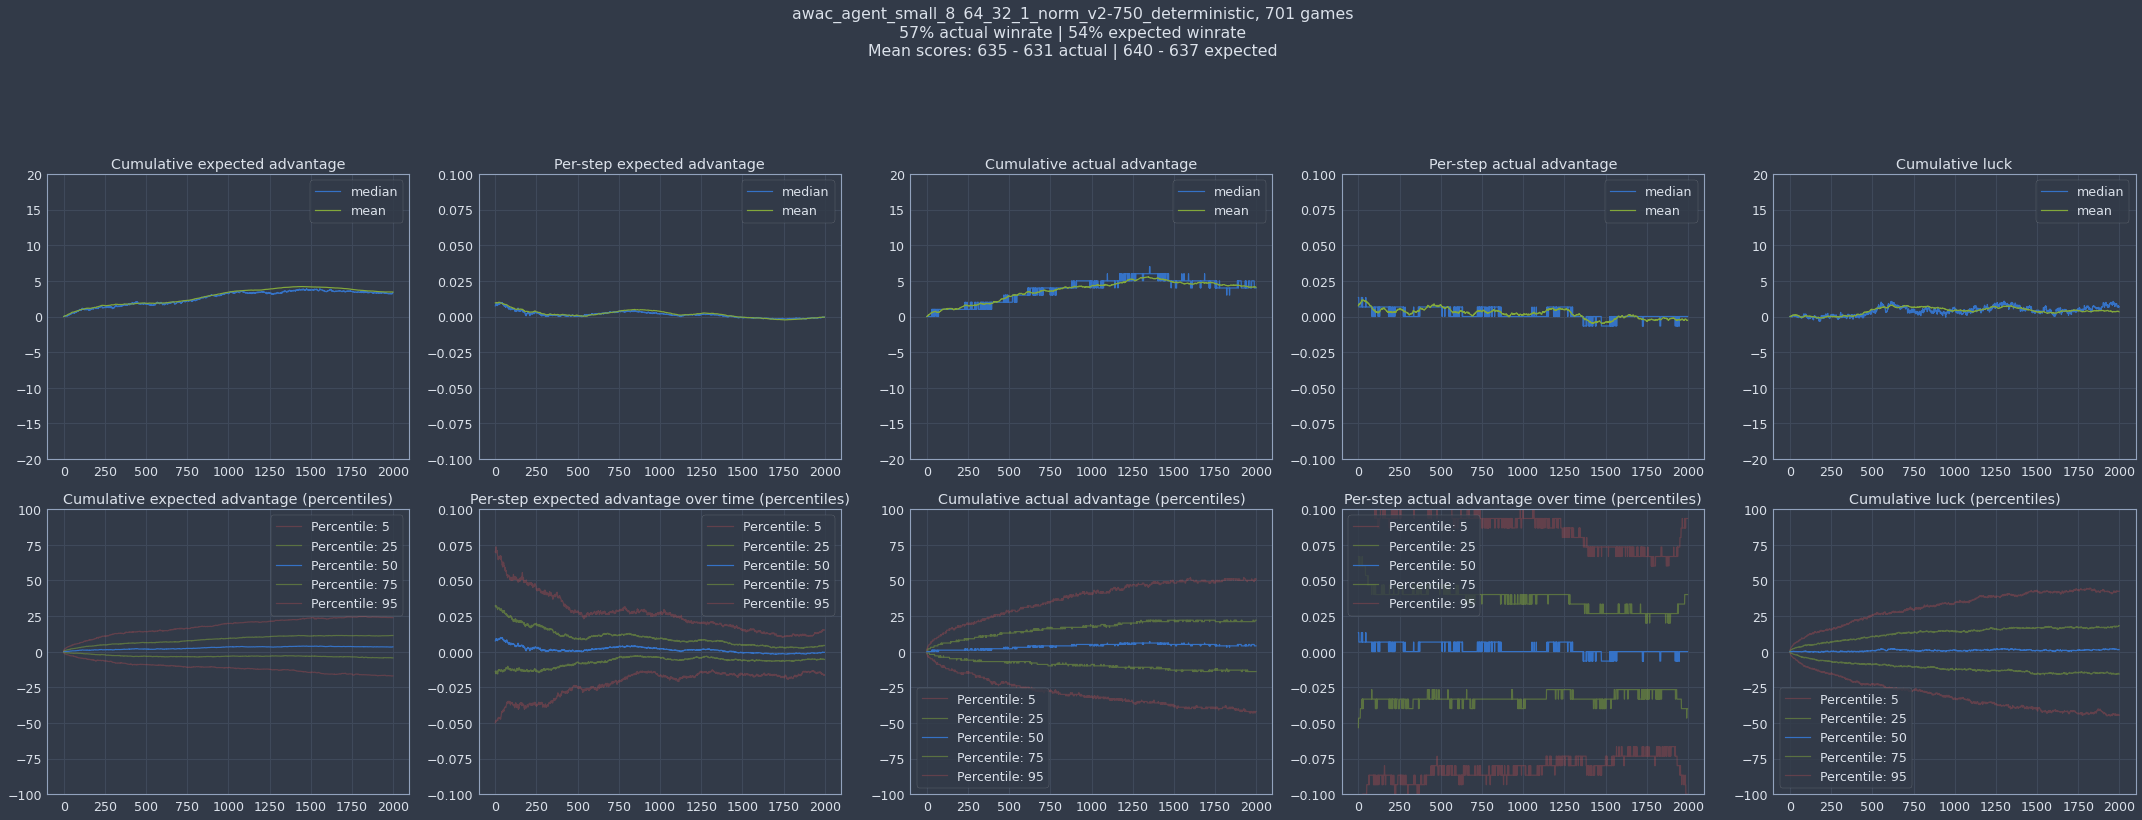

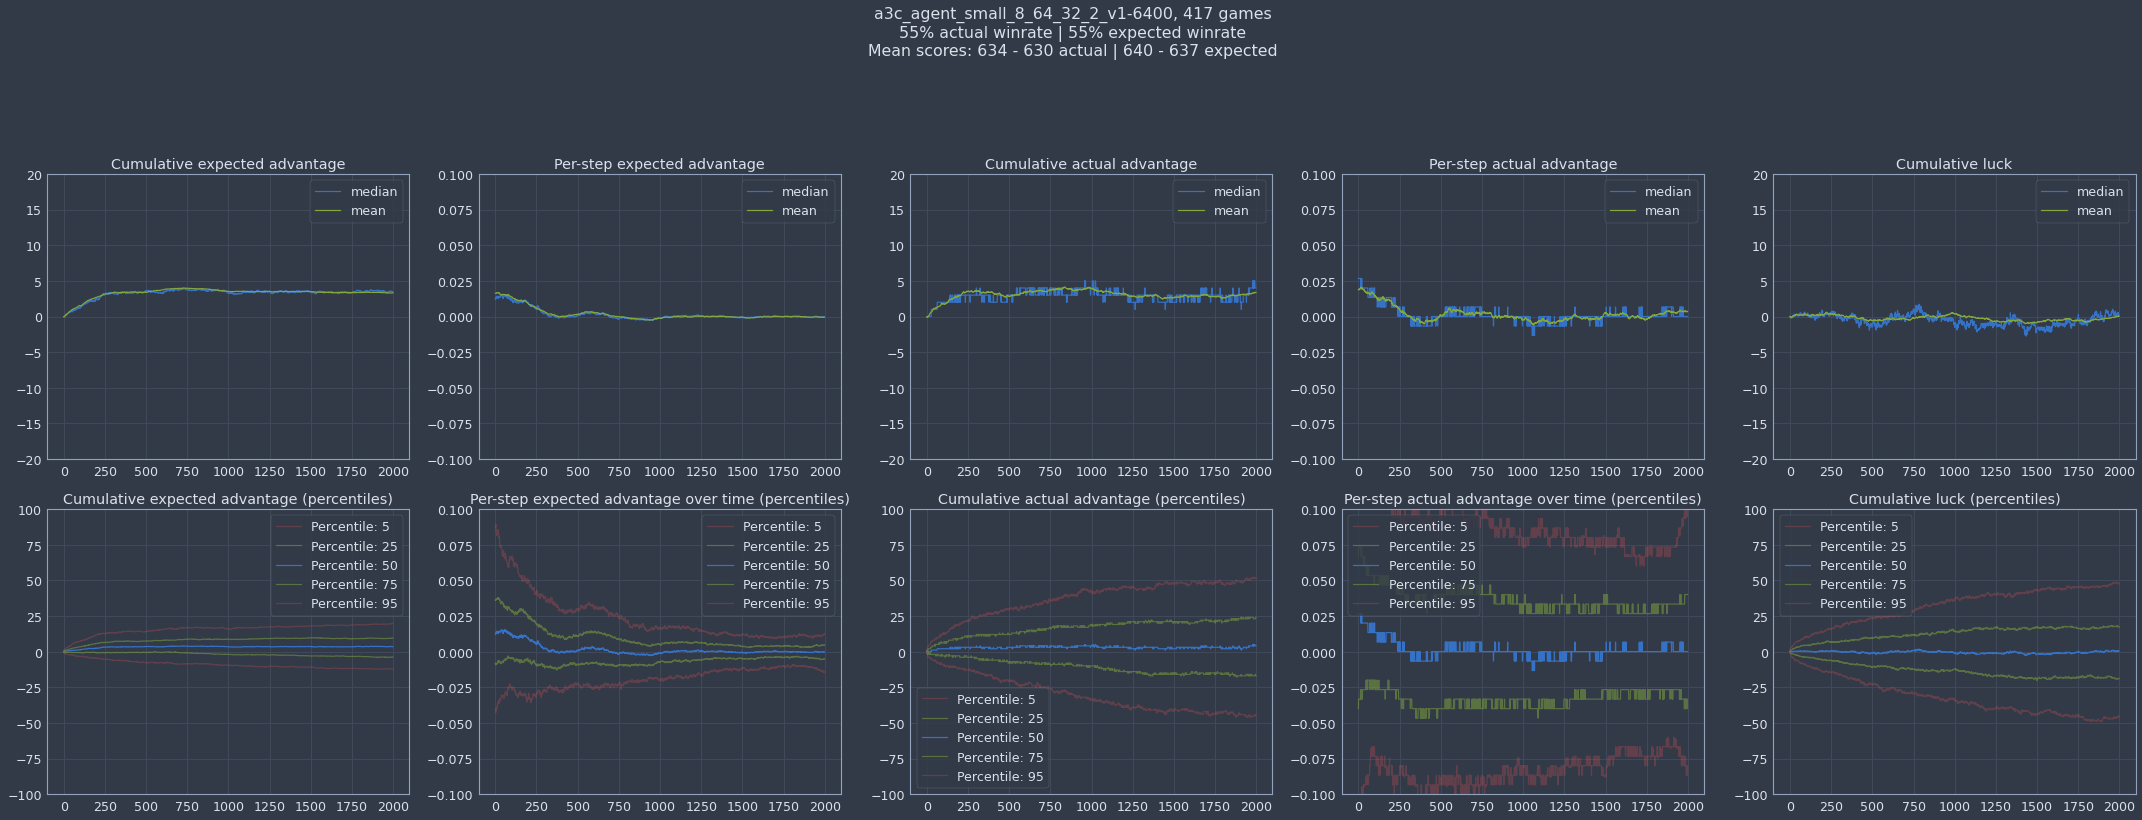

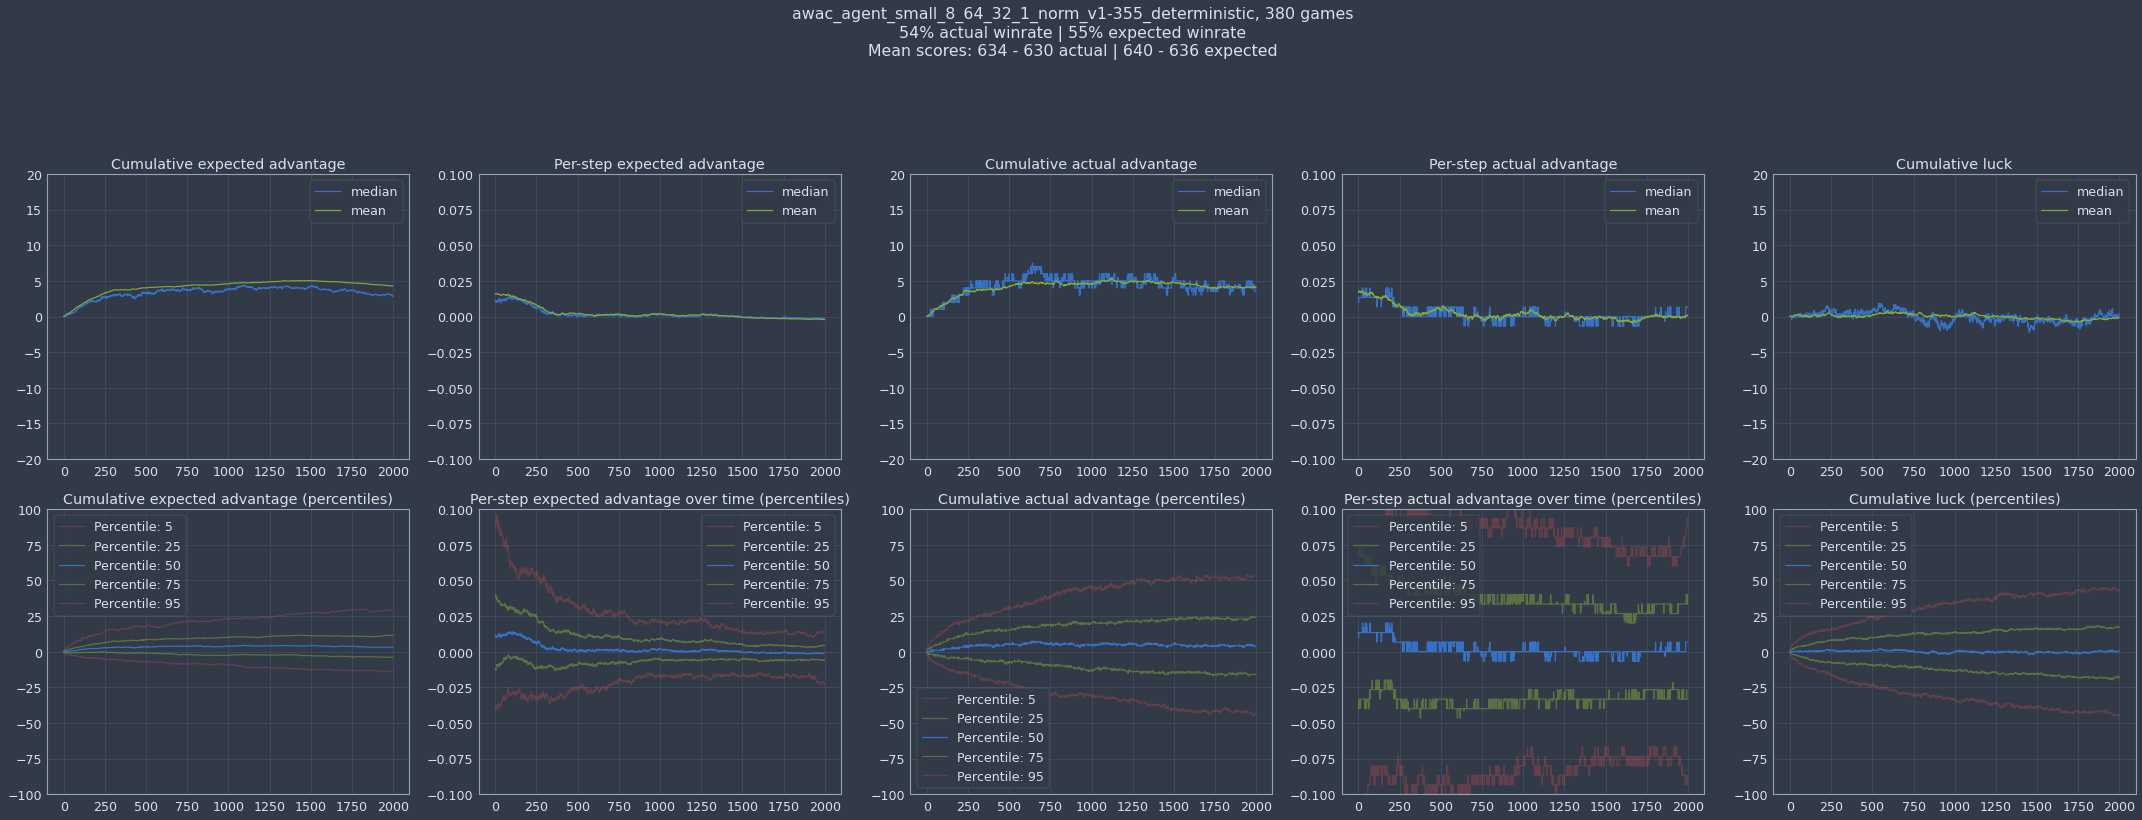

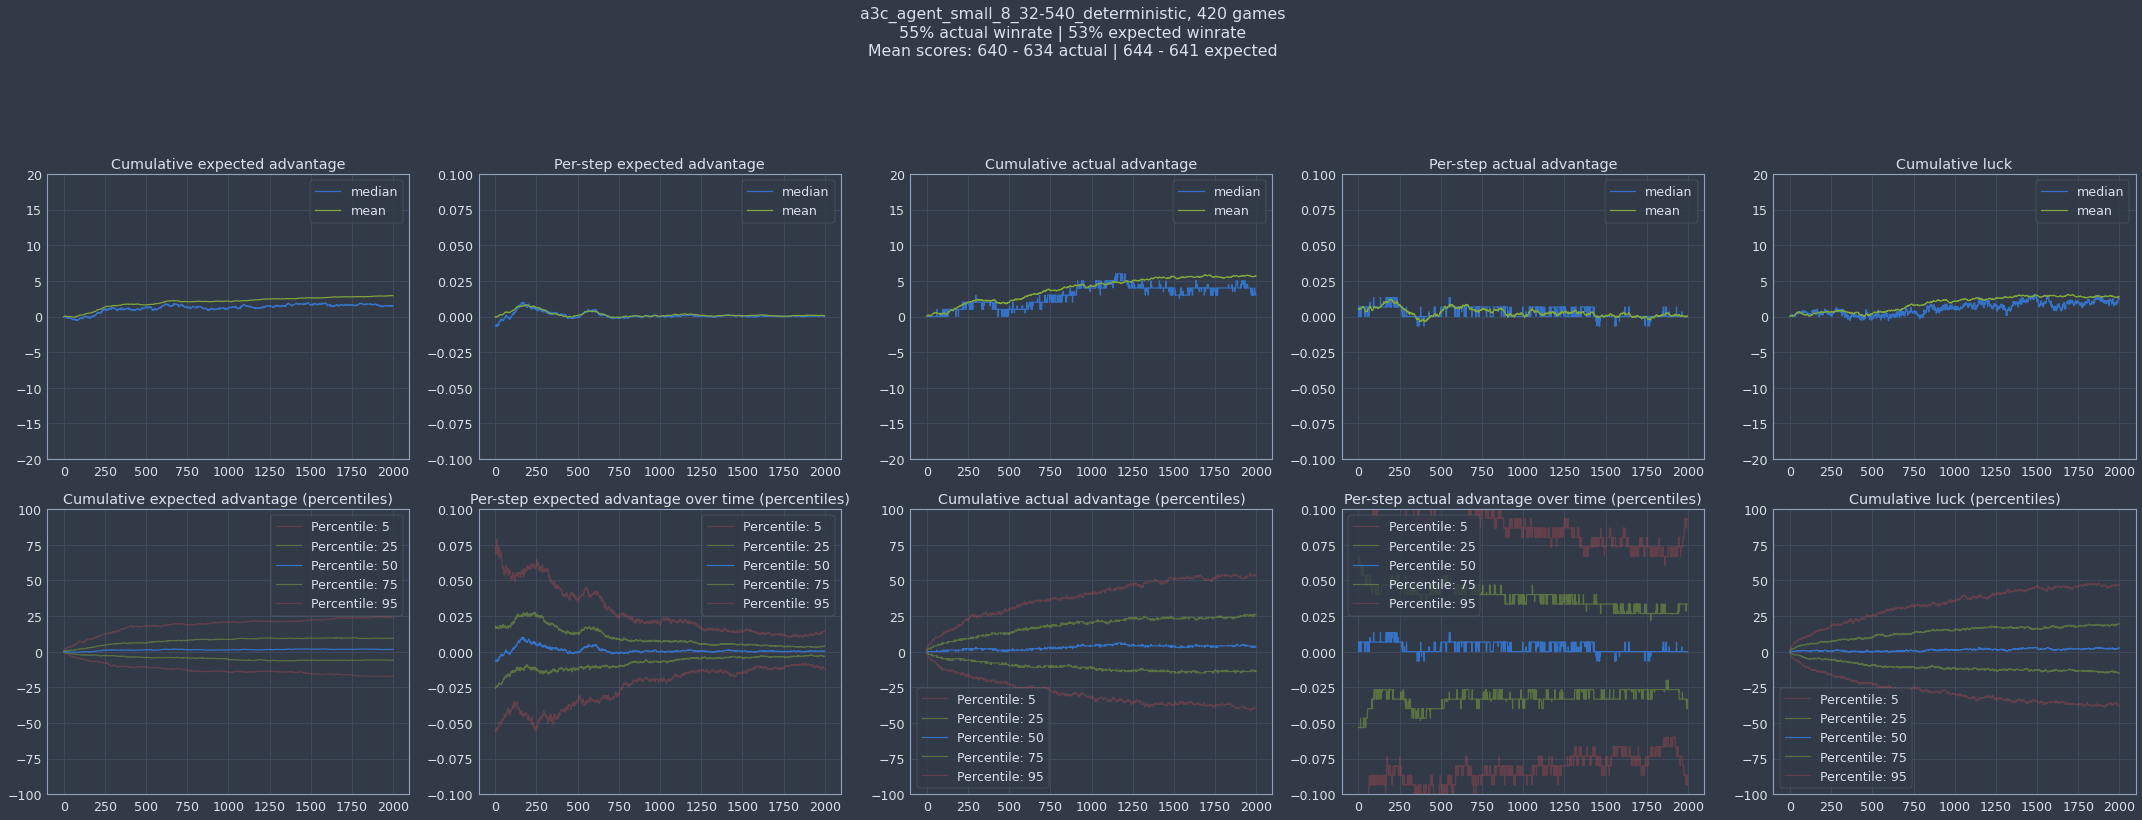

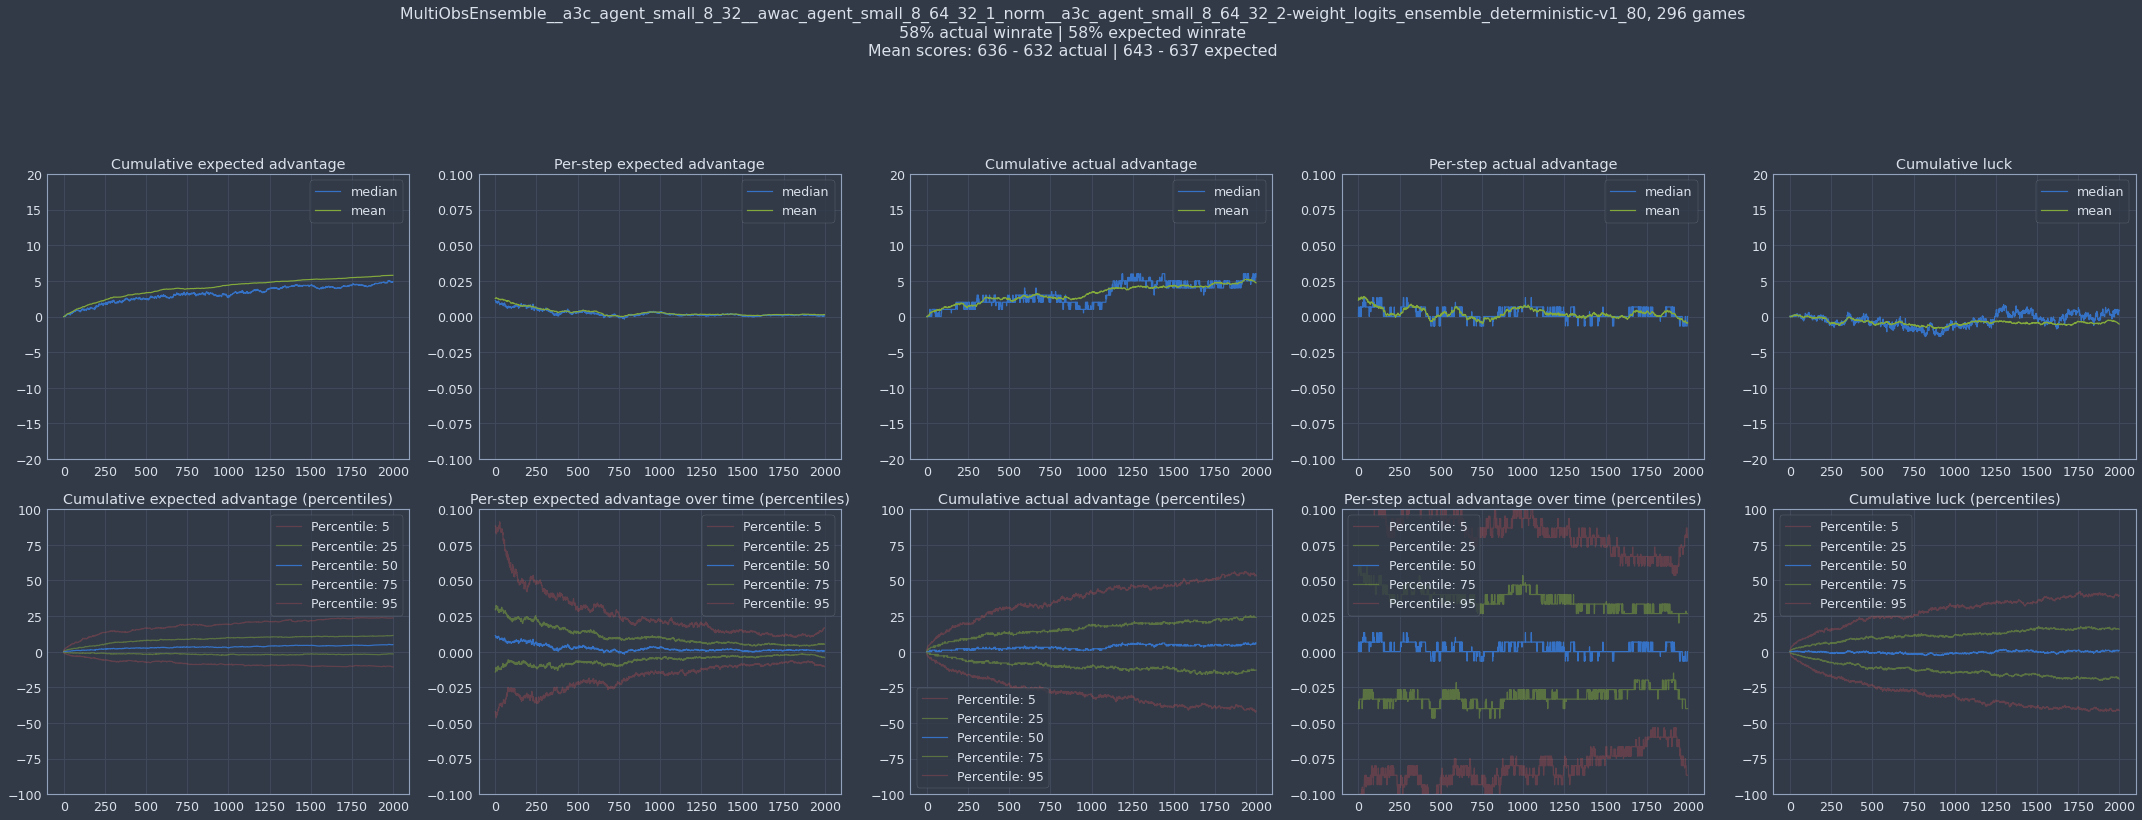

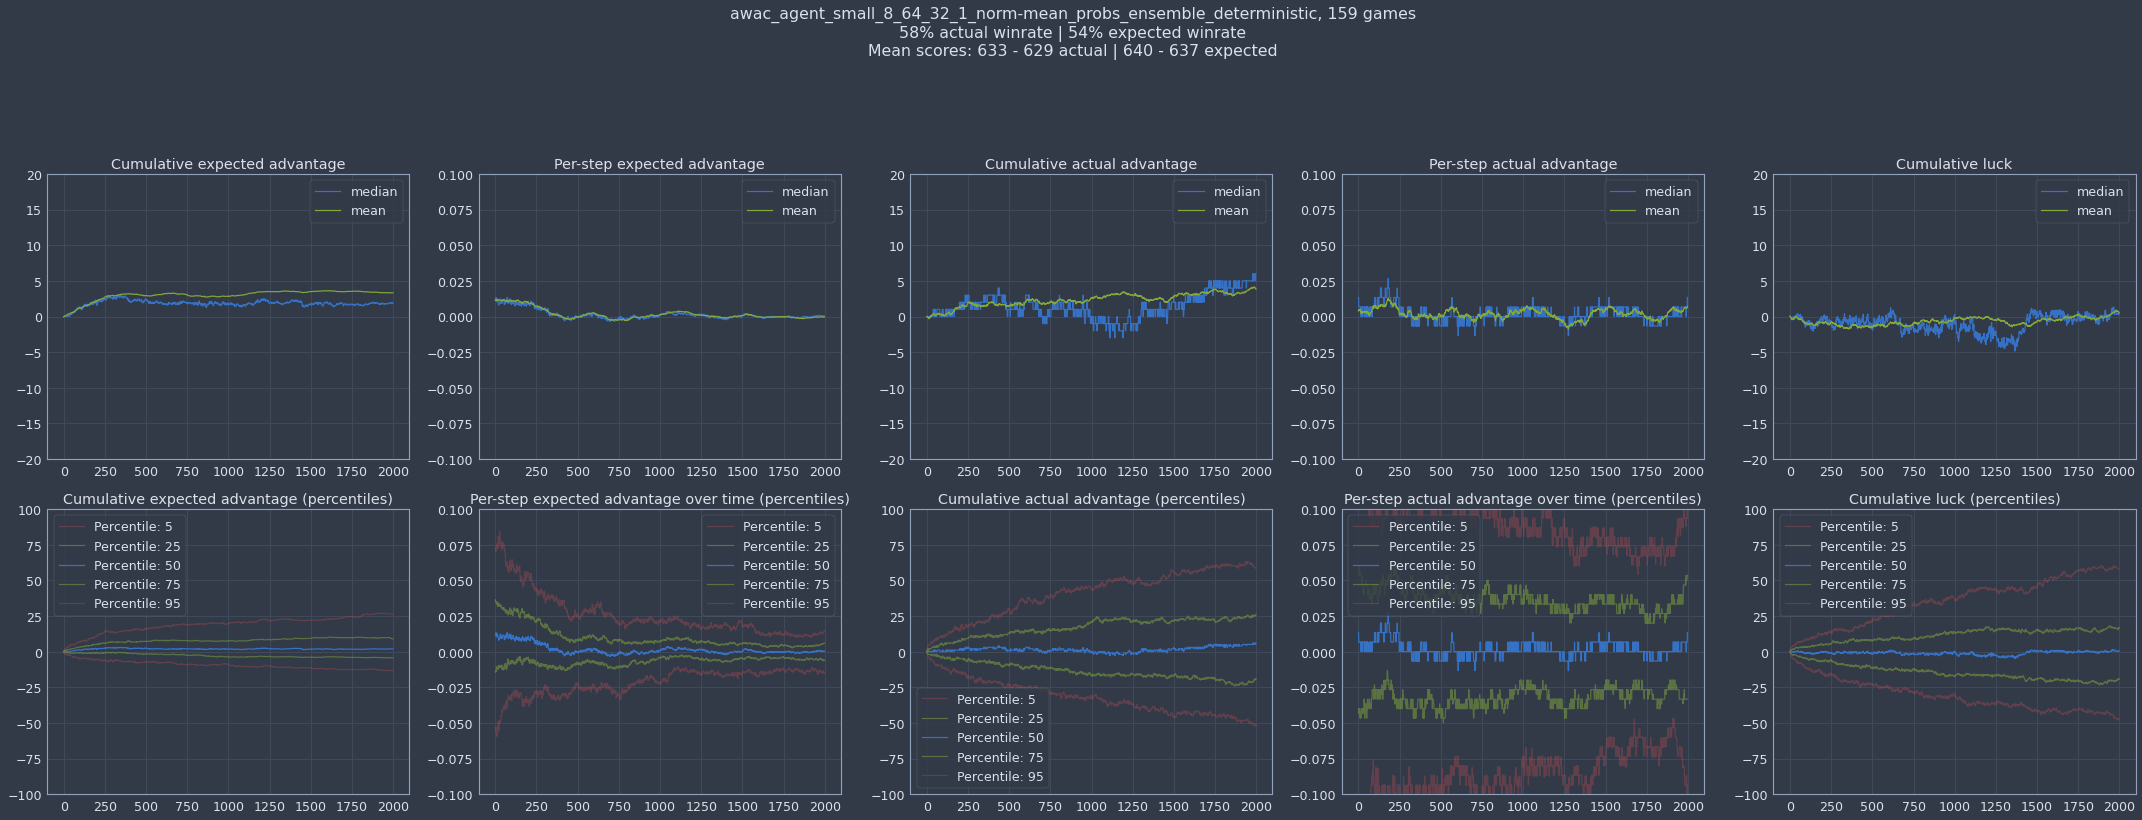

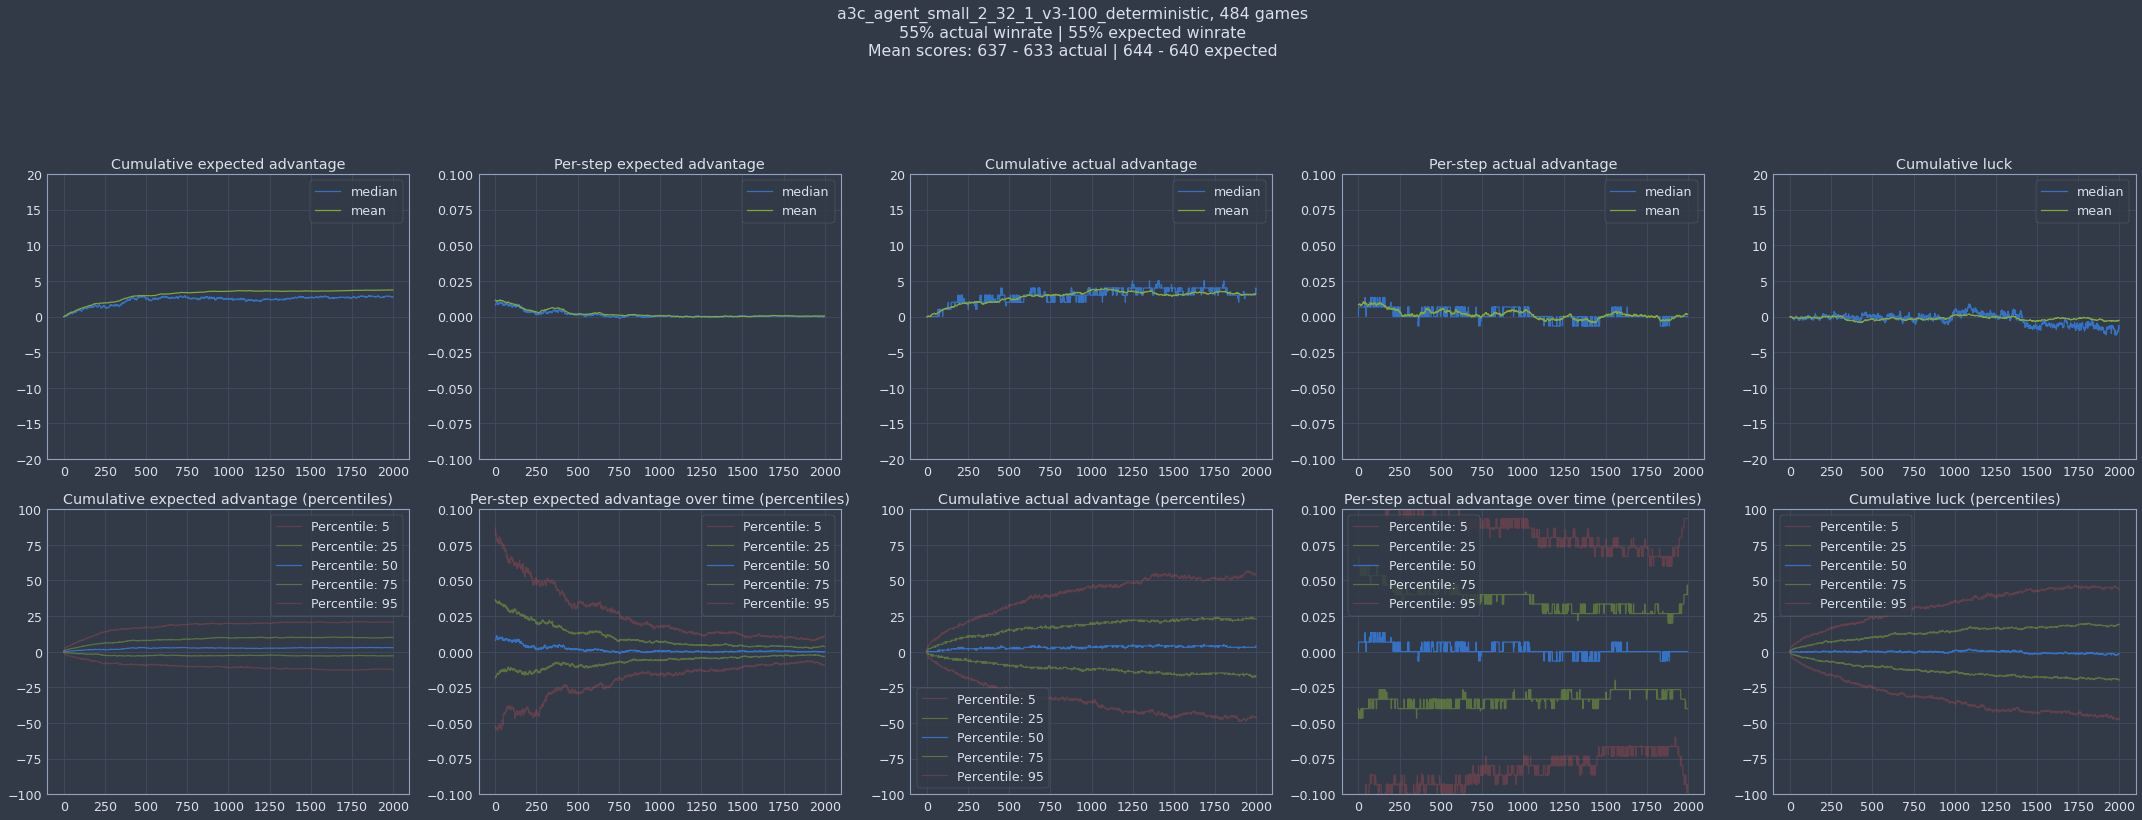

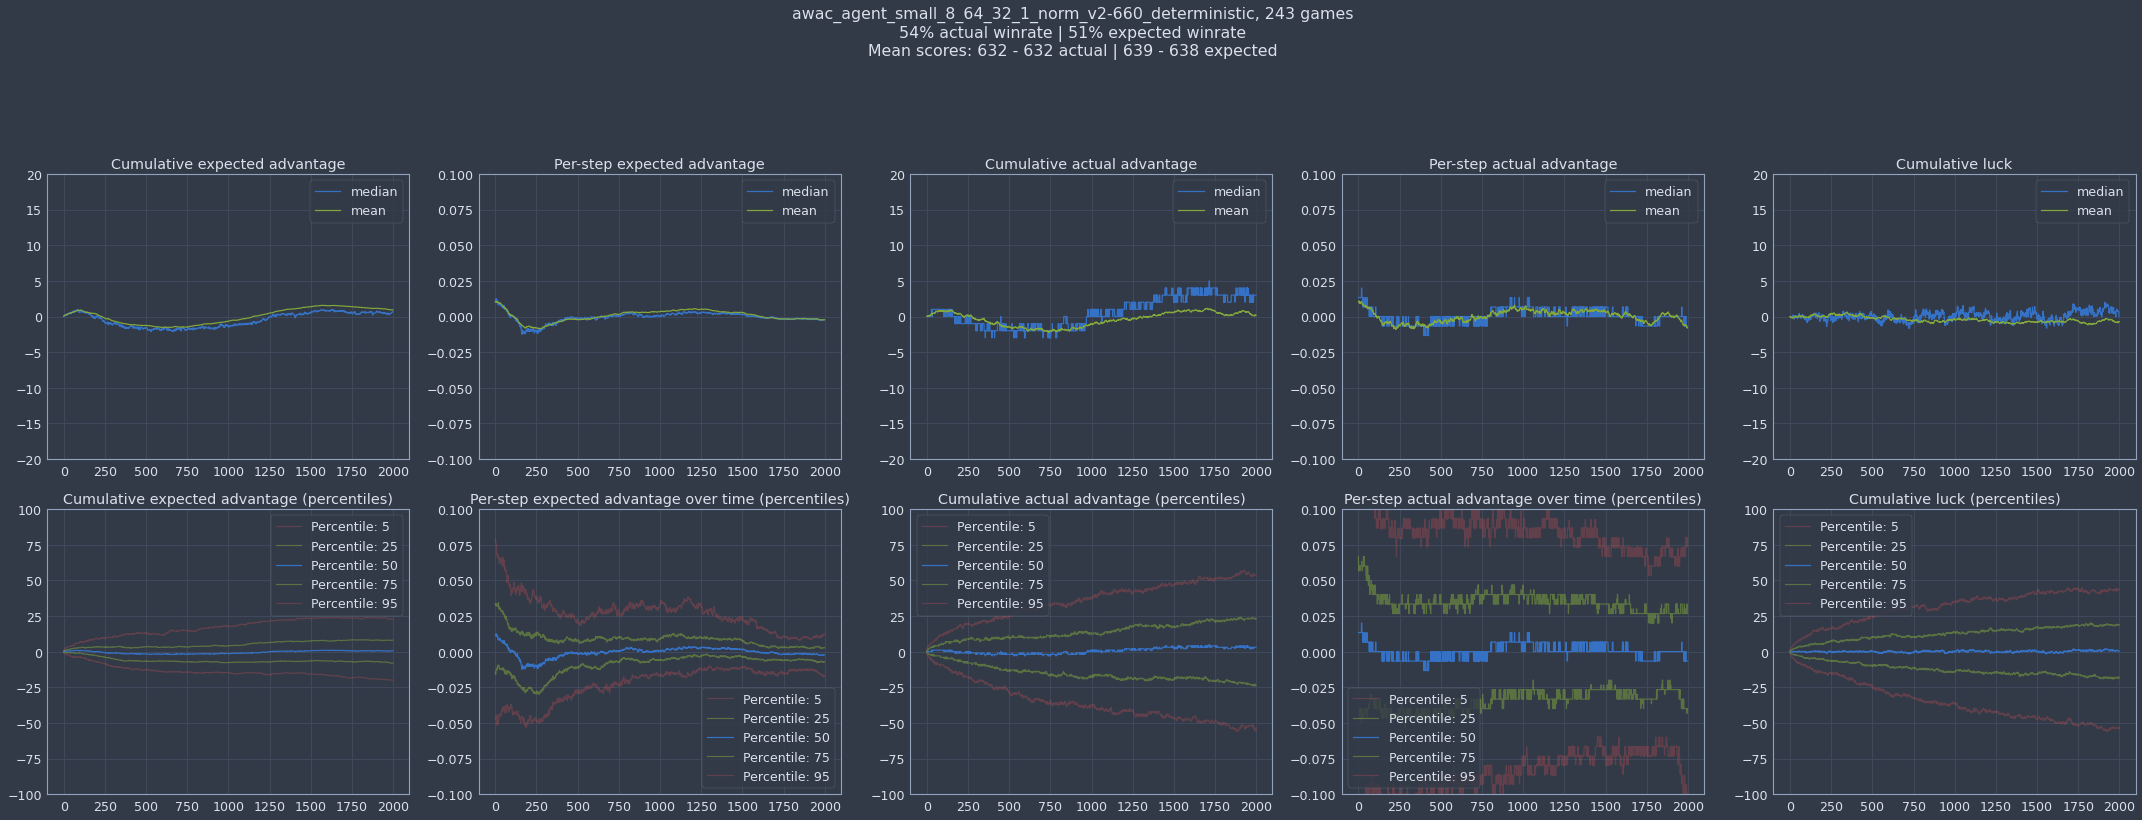

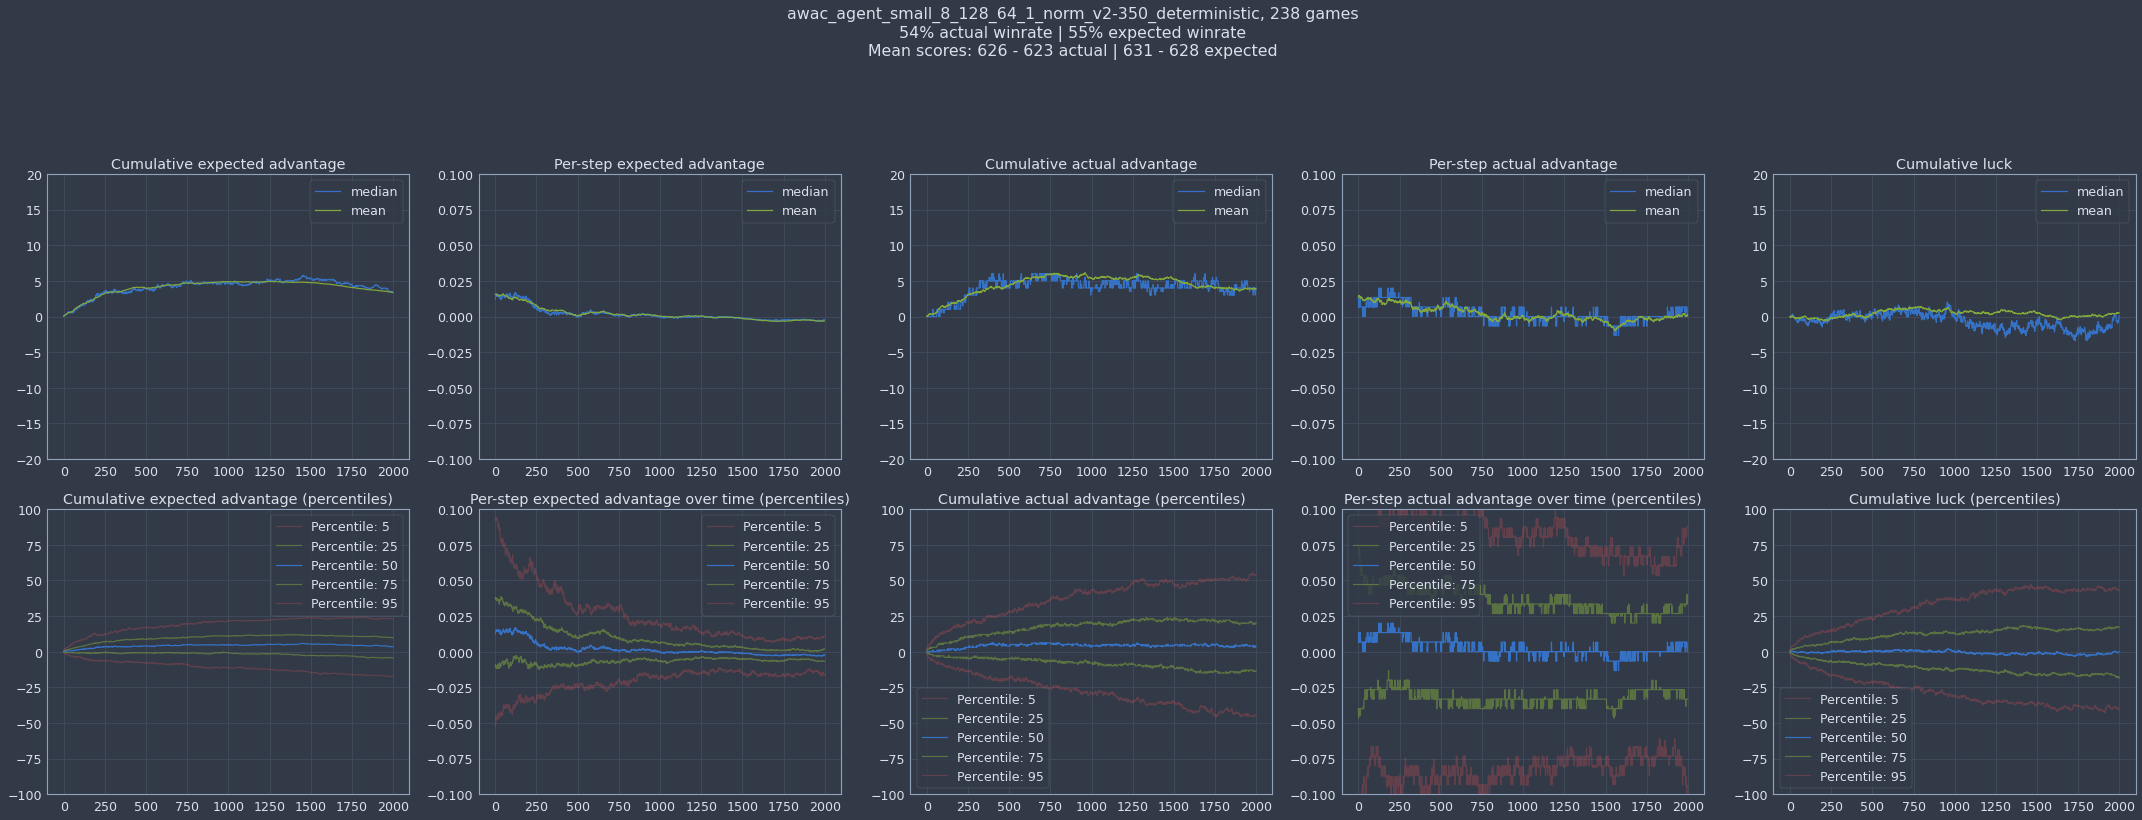

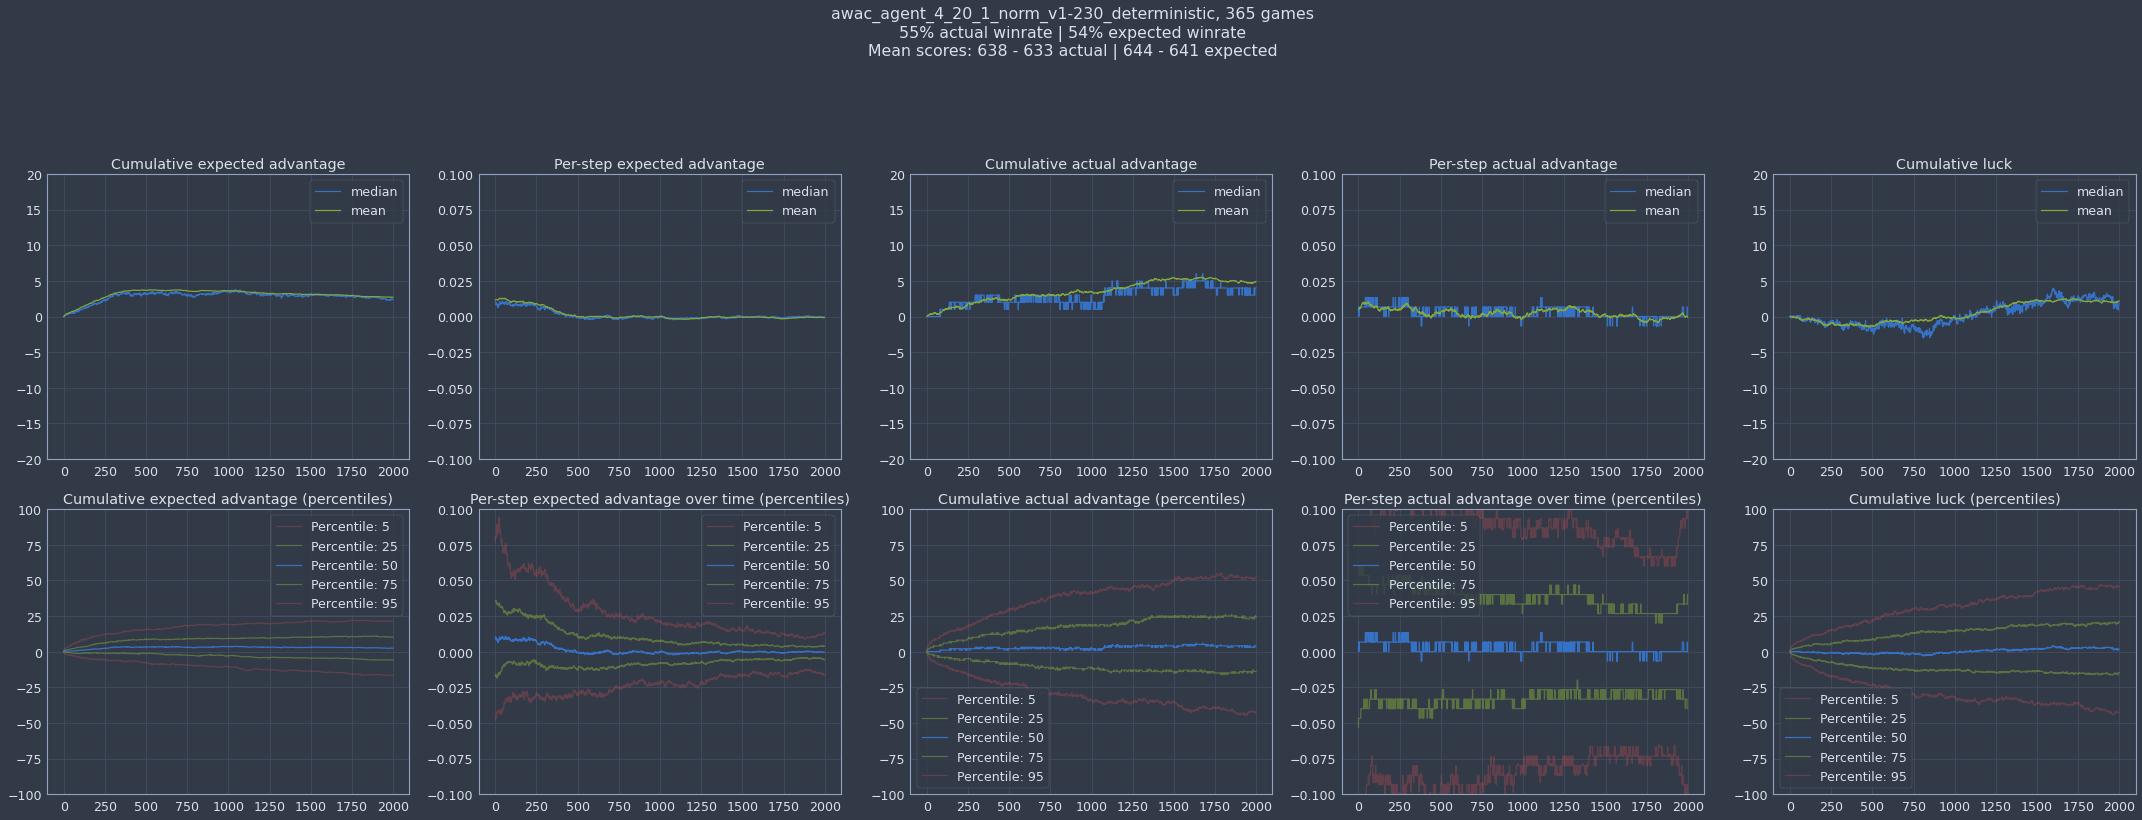

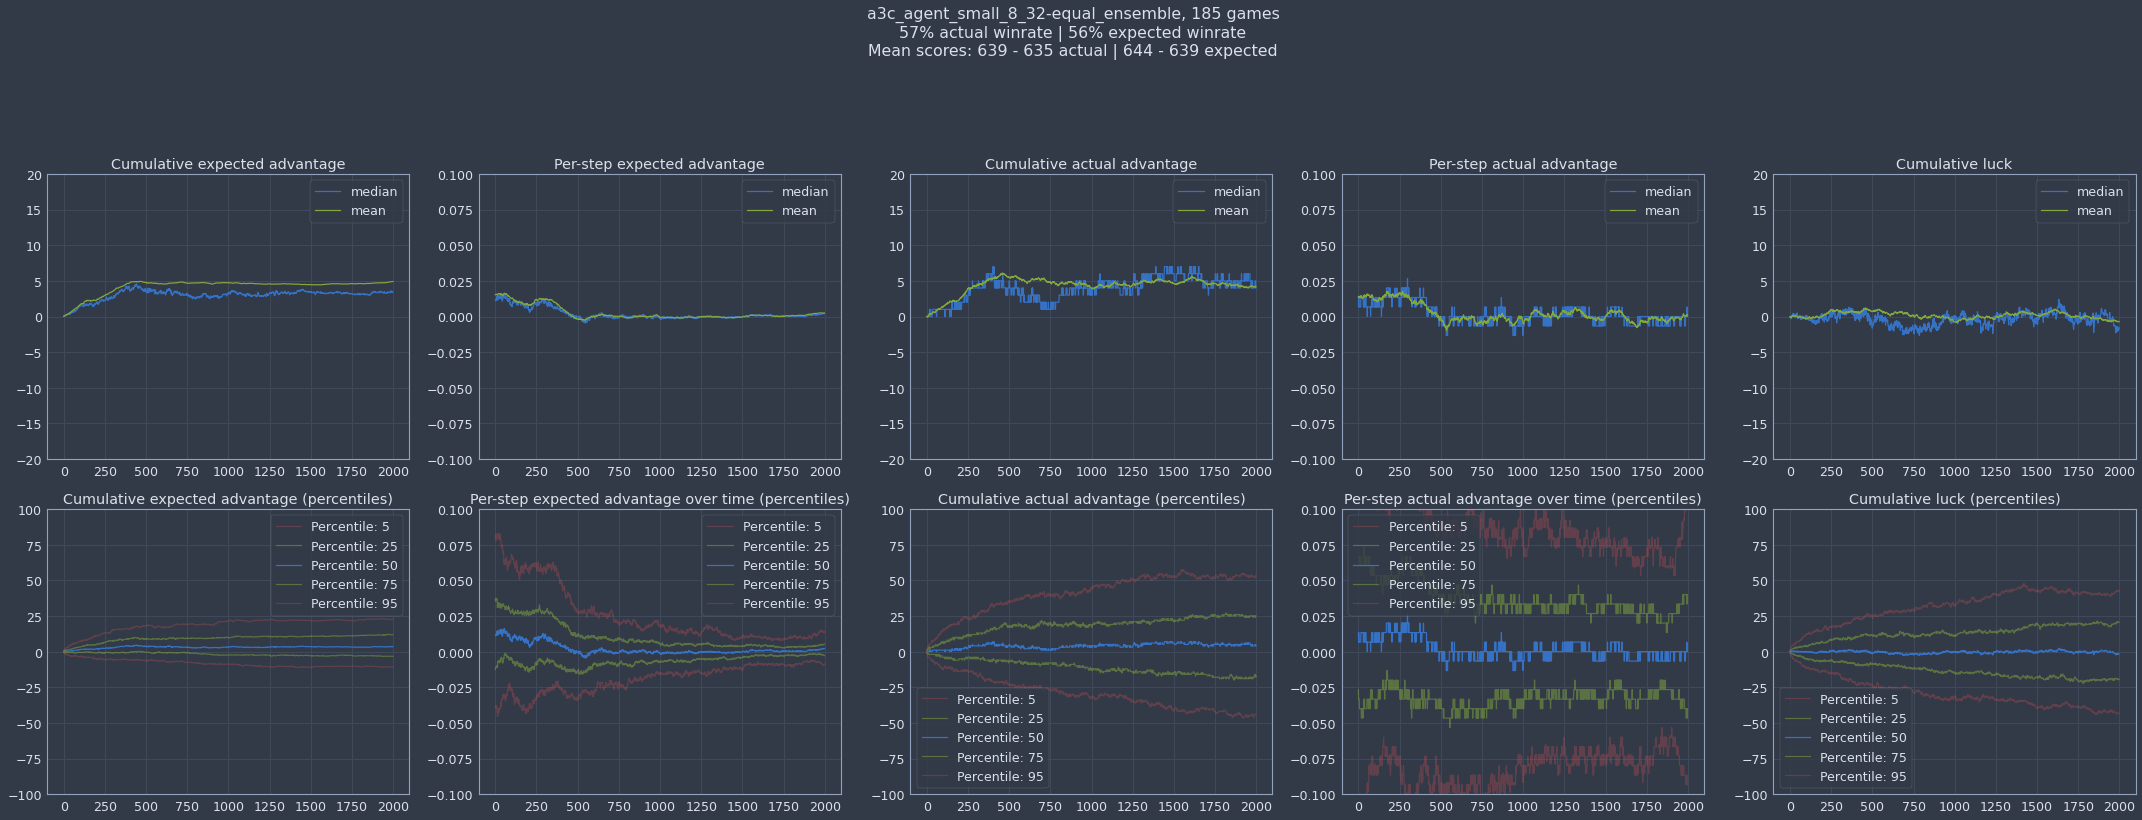

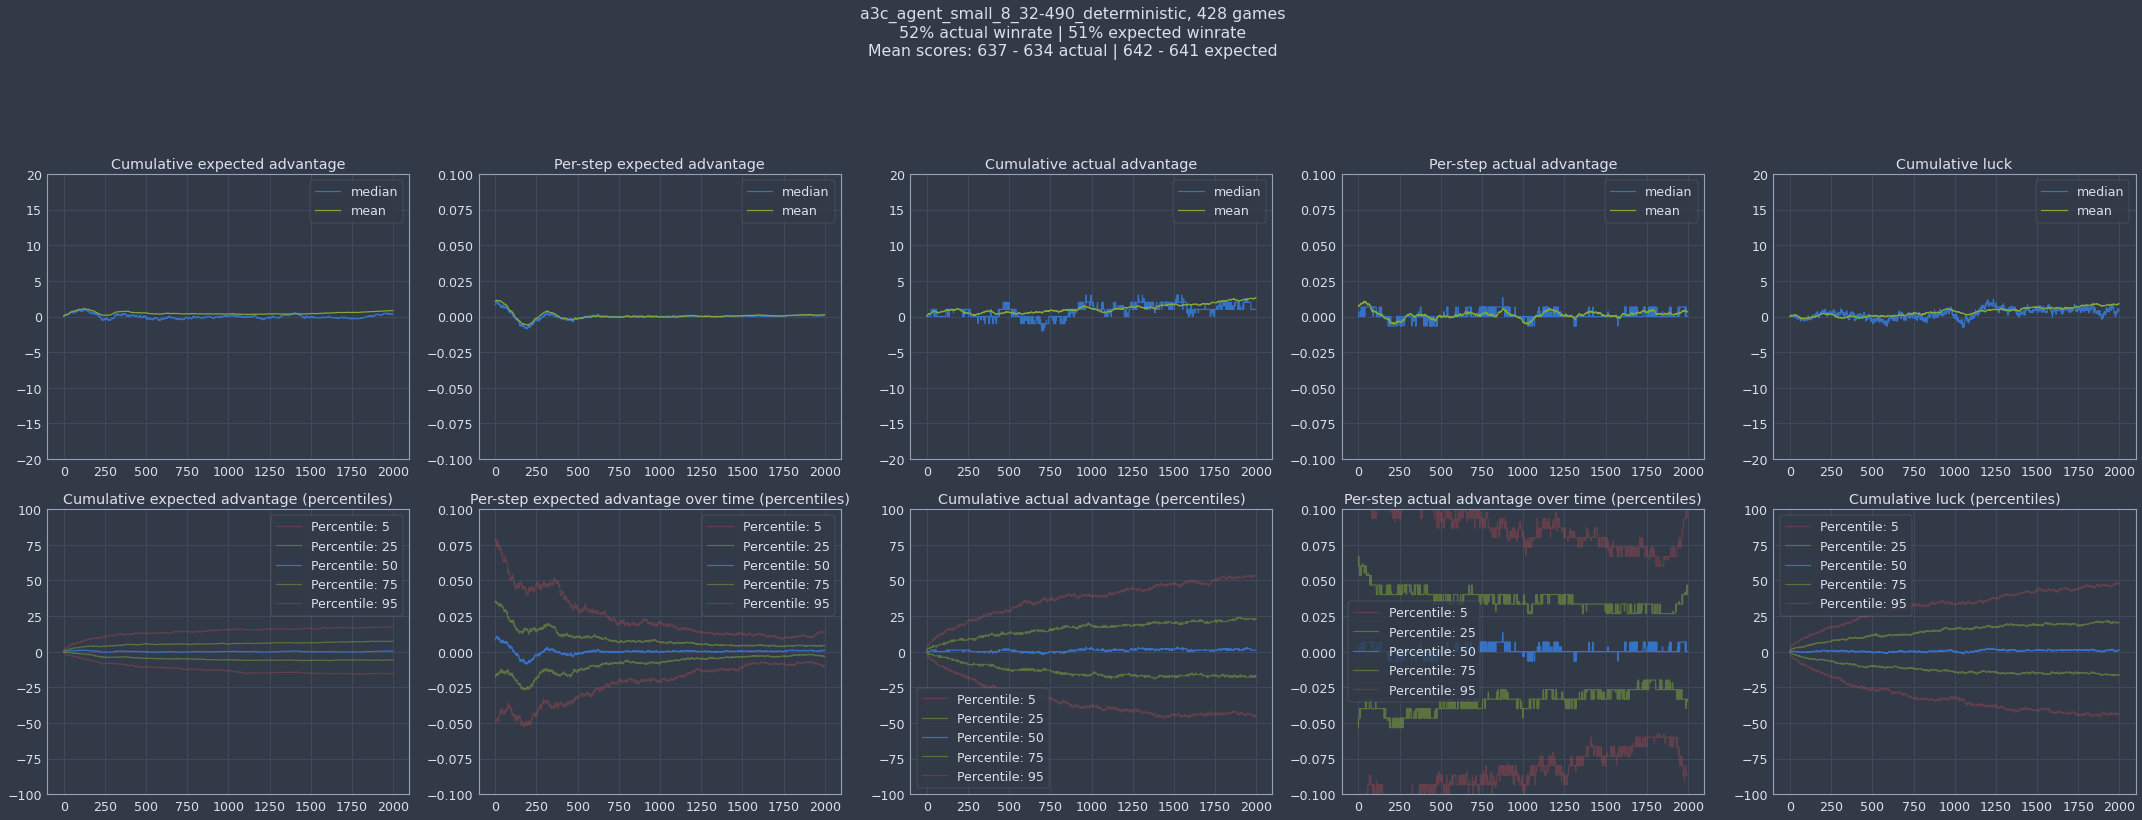

KeyboardInterrupt: 

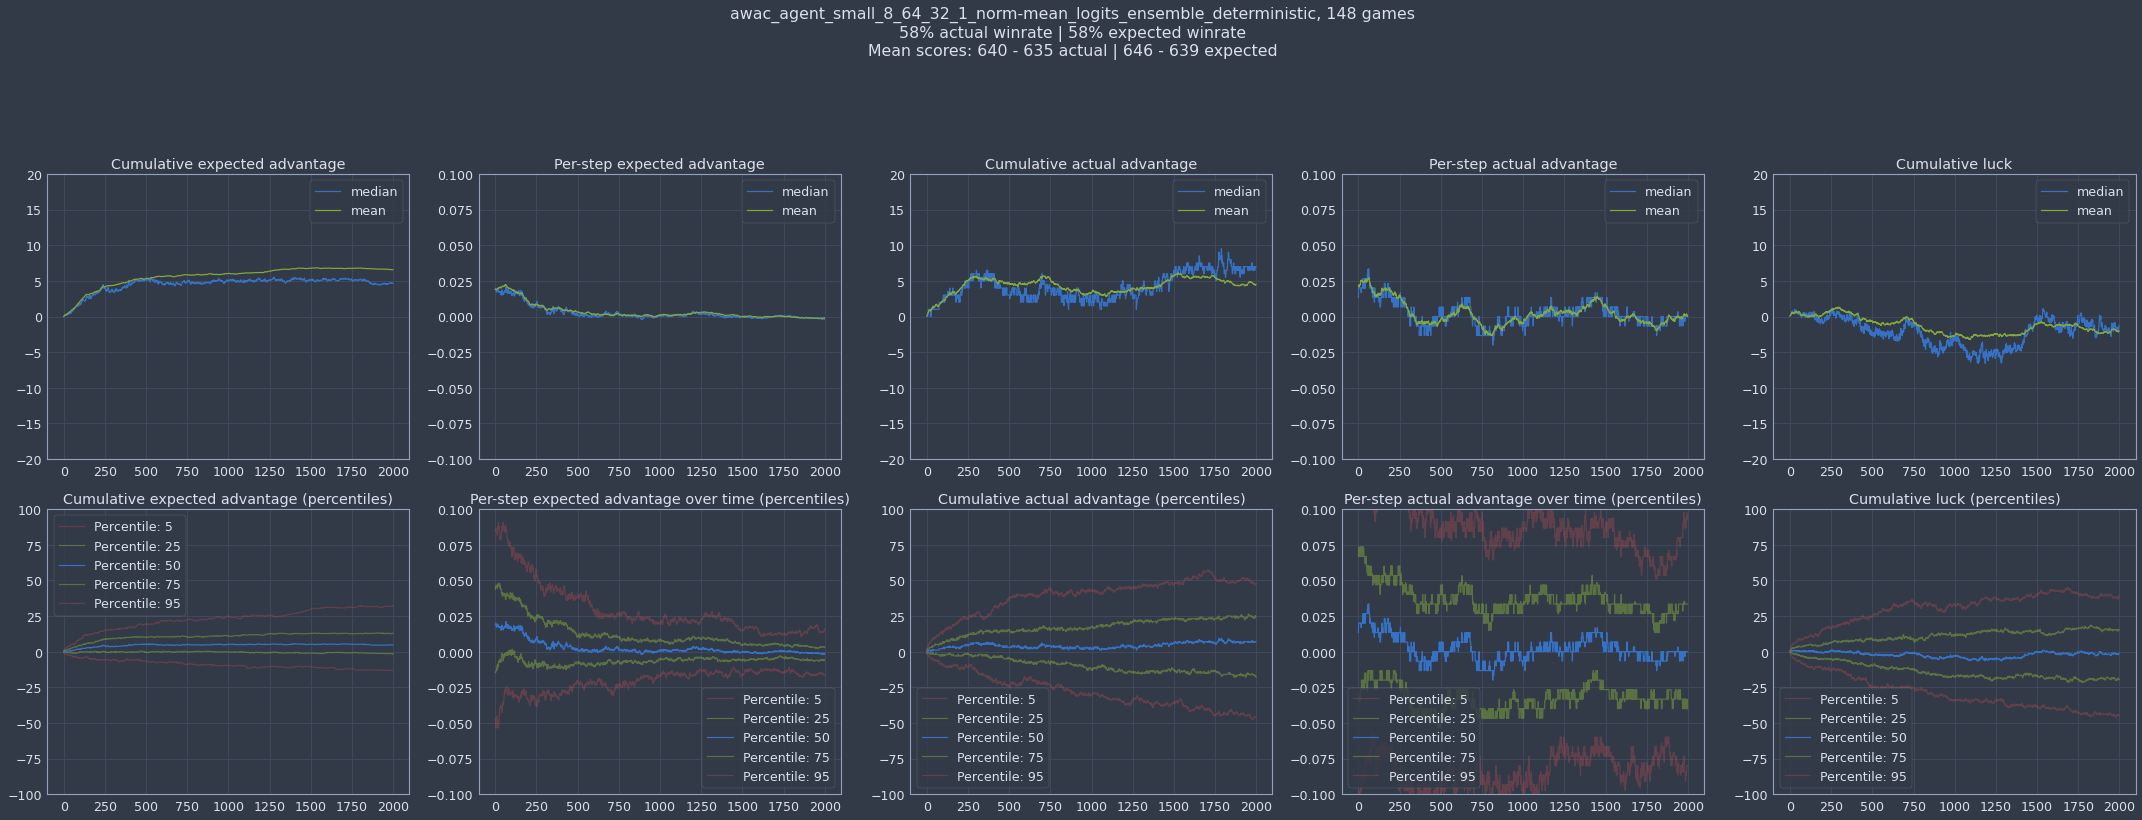

In [6]:
for mn in list(sub_id_to_model_name_df['model_name'].unique()):
    generate_fig(model_name=mn)

## Generate figures given specific model names

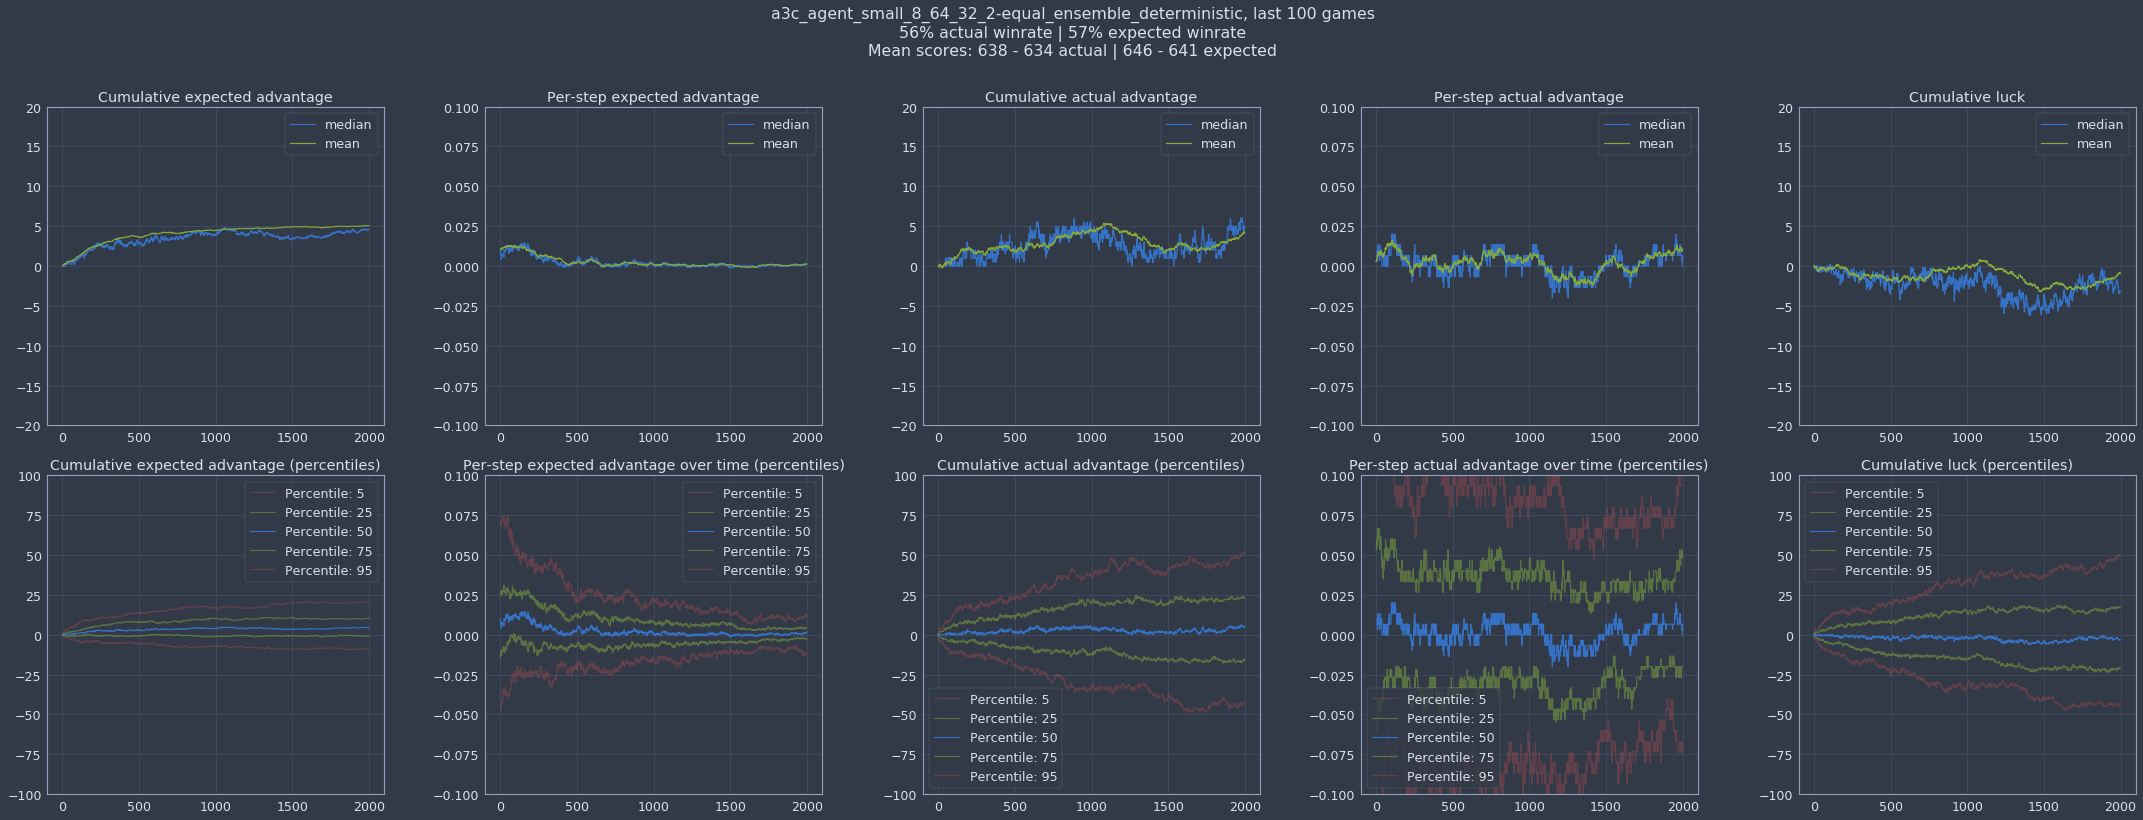

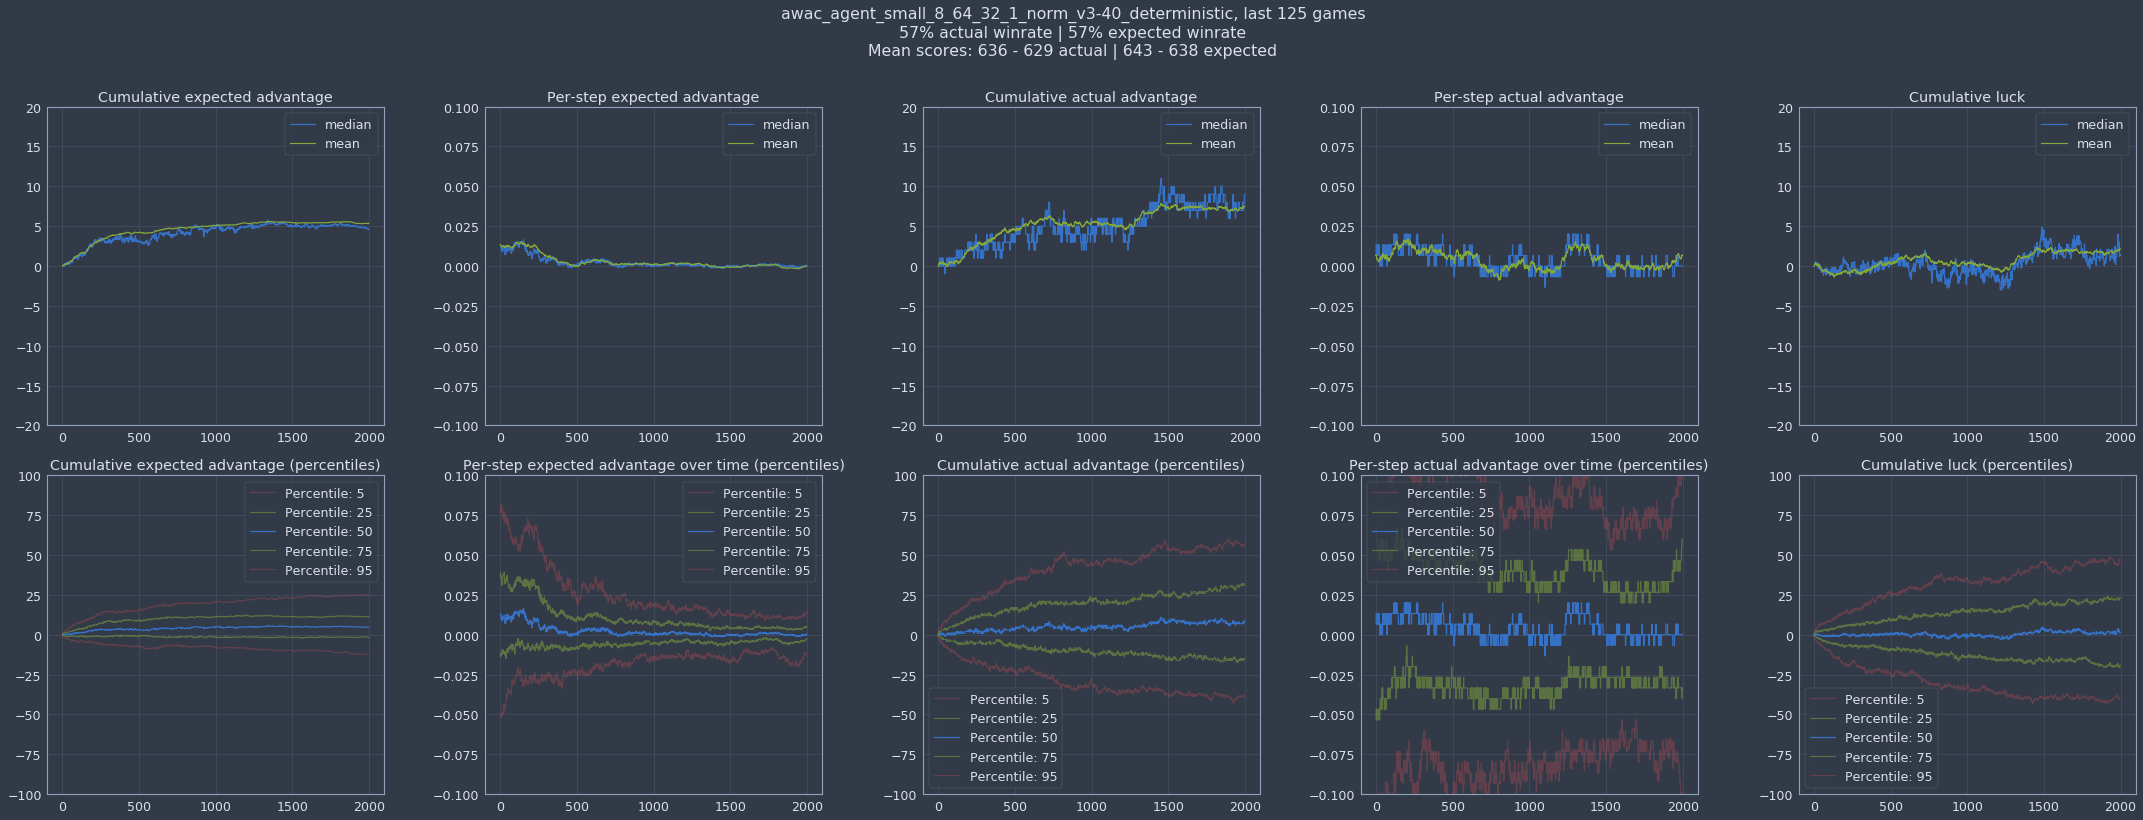

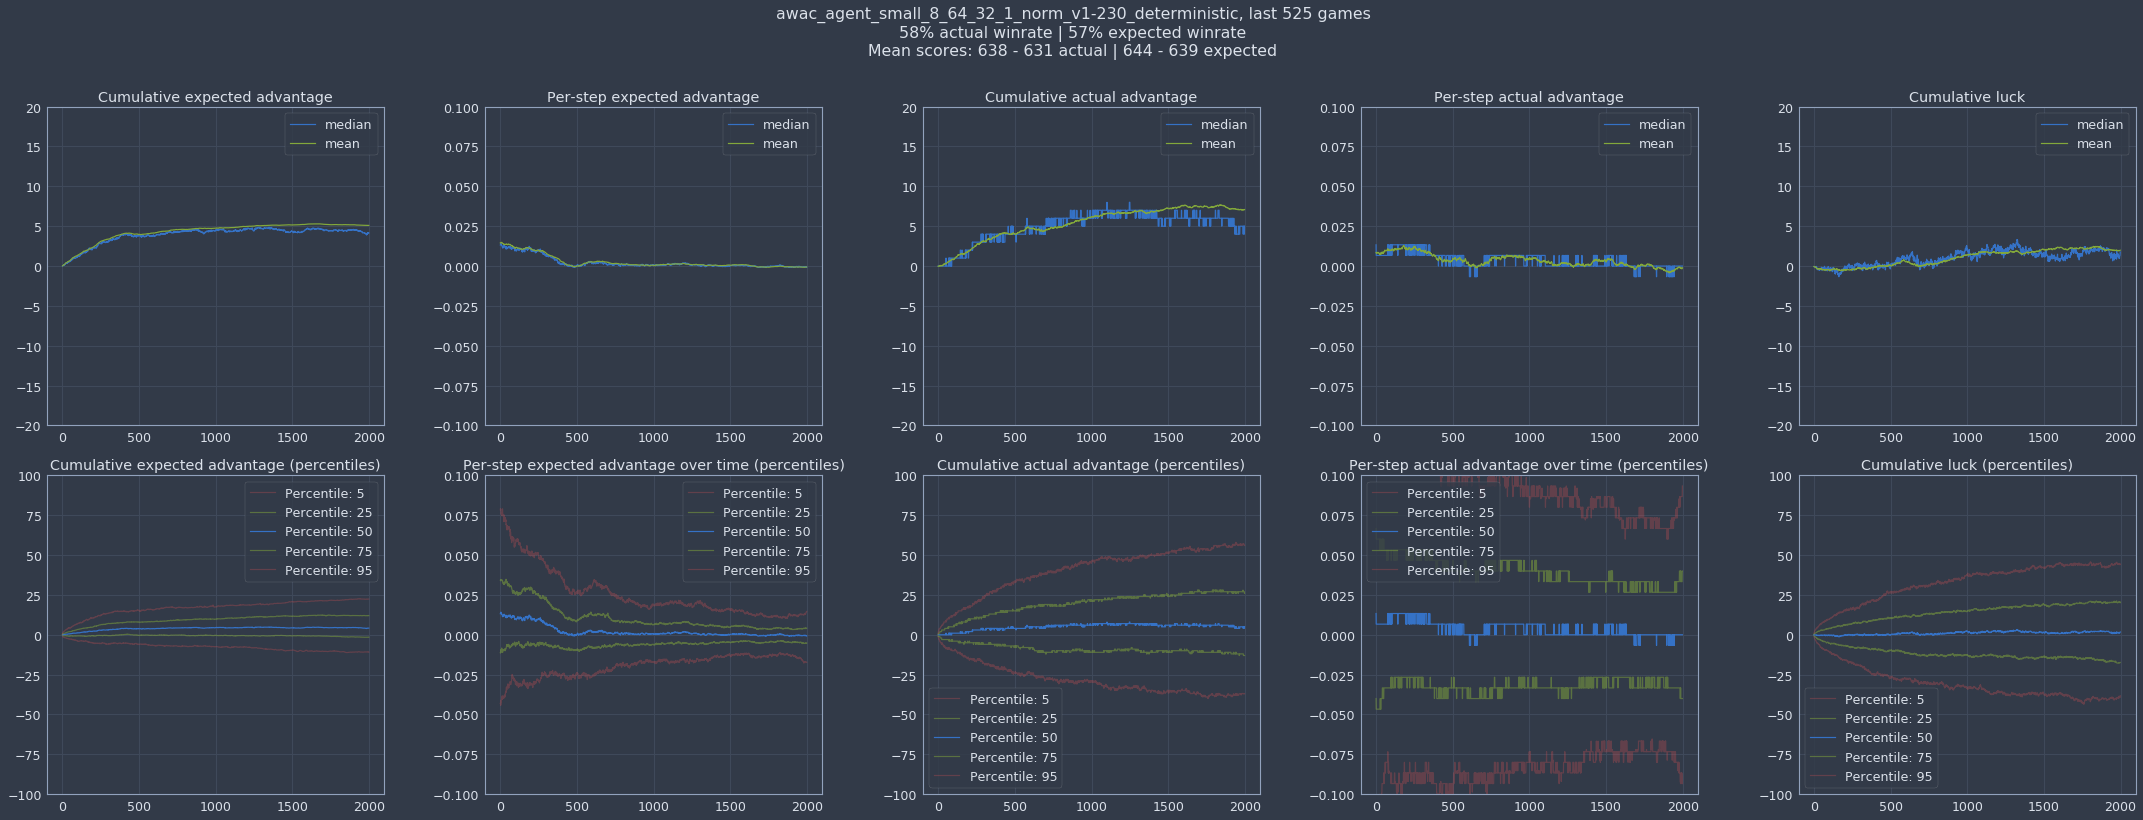

In [8]:
MODEL_NAMES = [
    'a3c_agent_small_8_64_32_2-equal_ensemble_deterministic',
    'awac_agent_small_8_64_32_1_norm_v3-40_deterministic',
    'awac_agent_small_8_64_32_1_norm_v1-230_deterministic'
]

for mn in MODEL_NAMES:
    generate_fig(
        model_name=mn,
        last_n_games=25,
        save=False
    )